In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/AL/Phd/maxml/caloml-atlas/'
plotpath = path_prefix+'regression/Plots_quantile/'
modelpath_c = path_prefix+'classifier/Models/'
modelpath = path_prefix+'regression/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [3]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu
import uproot as ur

Using TensorFlow backend.


In [4]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
import keras.backend as K

In [5]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [6]:
# import pi+

inputpath = path_prefix+'inputs/'
ptypes = ["pi0", "piplus"]
trees = {
    ptype : ur.open(inputpath+ptype+'.root')['ClusterTree']
    for ptype in ptypes
}
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pdata = {
    ptype : itree.pandas.df(branches, flatten=False)
    for ptype, itree in trees.items()
}

print("Number of pi0 events: {}".format(len(pdata['pi0'])))
print("Number of pi+ events: {}".format(len(pdata['piplus'])))

Number of pi0 events: 263891
Number of pi+ events: 435967


In [7]:
#define convenience columns
for ptype in ptypes:
    pdata[ptype]['clusterEoverCalib'] = pdata[ptype].clusterE / pdata[ptype].cluster_ENG_CALIB_TOT
    pdata[ptype]['clusterEoverTruth'] = pdata[ptype].clusterE / pdata[ptype].truthE
    pdata[ptype]['cluster_ENG_ALL'] = pdata[ptype].cluster_ENG_CALIB_TOT + pdata[ptype].cluster_ENG_CALIB_OUT_T + pdata[ptype].cluster_ENG_CALIB_DEAD_TOT

In [8]:
# regression variables: define up here to make it easier for later swapping

for ptype in ptypes:
    pdata[ptype]['logE'] = np.log(pdata[ptype].clusterE)
    pdata[ptype]['logECalib'] = np.log(pdata[ptype].cluster_ENG_CALIB_TOT)
    pdata[ptype]['logECalibAll'] = np.log(pdata[ptype].cluster_ENG_ALL)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler_cal = {}
for ptype in ptypes:
    # create scaler
    scaler_e = StandardScaler()
    scaler_cal[ptype] = StandardScaler()
    scaler_calAll = StandardScaler()
    # fit and transform in one step
    pdata[ptype]['s_logE'] = scaler_e.fit_transform(pdata[ptype]['logE'].to_numpy().reshape(-1,1))
    pdata[ptype]['s_logECalib'] = scaler_cal[ptype].fit_transform(pdata[ptype]['logECalib'].to_numpy().reshape(-1,1))
    pdata[ptype]['s_logECalibAll'] = scaler_calAll.fit_transform(pdata[ptype]['logECalibAll'].to_numpy().reshape(-1,1))


In [10]:
# fun cleaning for EMProb
epsilon = 0.000000000001

for ptype in ptypes:
    pdata[ptype]['cluster_fixEM'] = pdata[ptype].cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)

In [11]:
for ptype in ptypes:
    pdata[ptype]['cluster_logEM'] = np.log(pdata[ptype].cluster_fixEM)

    scaler_EM = StandardScaler()
    pdata[ptype]['s_logEM'] = scaler_EM.fit_transform(pdata[ptype].cluster_logEM.to_numpy().reshape(-1,1))

    scaler_eta = StandardScaler()
    pdata[ptype]['s_eta'] = scaler_eta.fit_transform(pdata[ptype].clusterEta.to_numpy().reshape(-1,1))

    pdata[ptype]['logCenter'] = np.log(pdata[ptype].cluster_CENTER_MAG)
    scaler_center = StandardScaler()
    pdata[ptype]['s_logCenter'] = scaler_center.fit_transform(pdata[ptype].logCenter.to_numpy().reshape(-1,1))

    scaler_density = StandardScaler()
    pdata[ptype]['s_Density'] = scaler_density.fit_transform(pdata[ptype].cluster_FIRST_ENG_DENS.to_numpy().reshape(-1,1))

In [12]:
# define convience sub-frames

for ptype in ptypes:
    pdata[ptype]['Single'] = pdata[ptype].nCluster==1 # define a subset of events with only one cluster
    mu.splitFrameTVT(pdata[ptype], trainfrac = 0.7)   # define a train/test fraction of 70/20% (10% for val at this point)

In [13]:
All_input = {}

for ptype in ptypes:
    EMB1_cells = mu.setupCells(trees[ptype], 'EMB1') # implicitly flatten
    EMB2_cells = mu.setupCells(trees[ptype], 'EMB2')
    EMB3_cells = mu.setupCells(trees[ptype], 'EMB3') # implicitly flatten

    TileBar0_cells = mu.setupCells(trees[ptype], 'TileBar0') # implicitly flatten
    TileBar1_cells = mu.setupCells(trees[ptype], 'TileBar1') # implicitly flatten
    TileBar2_cells = mu.setupCells(trees[ptype], 'TileBar2') # implicitly flatten

    combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
    s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
    All_input[ptype] = np.column_stack((pdata[ptype]['s_logE'],pdata[ptype]['s_eta'],s_All_cells))

In [14]:
quantiles = [0.16, 0.5, 0.84]

def GAE(y_true, y_pred):
    sgn = -(y_true - y_pred) / K.abs(y_true - y_pred)
    return (0.5-sgn*0.5+sgn*0.84)*K.abs(y_true - y_pred)

def get_GAE(q):
    def GAE_q(y_true, y_pred):
#         if( (y_true - y_pred) == 0 ):
#             return 0.0
        sgn = -(y_true - y_pred) / (K.abs(y_true - y_pred)+K.epsilon())
        return (0.5-sgn*0.5+sgn*q)*K.abs(y_true - y_pred)
    return GAE_q

quantile_loss = [
    get_GAE(q) for q in quantiles
]

In [15]:
regressor_q = []
for q,loss in zip(quantiles,quantile_loss):
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    used_pixels = number_pixels + 2
    regressor_q.append(Sequential([
        Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'),
        Dense(used_pixels, activation='relu'),
        Dense(int(used_pixels/2), activation='relu'),
        Dense(units=1, kernel_initializer='normal', activation='linear'),
    ]))
    
    opt = Adam(lr=1e-4, decay=1e-6)
    regressor_q[-1].compile(optimizer=opt, loss=get_GAE(q), metrics=['mae','mse'])

In [16]:
# train models
for rq in regressor_q:
    history = rq.fit(
        All_input['piplus'][pdata['piplus'].train],
        pdata['piplus'][pdata['piplus'].train].s_logECalib.to_numpy(),
        batch_size=200*ngpu, epochs=50
    )

Train on 305176 samples
Epoch 1/50
305176/305176 [==============================] - 7s 24us/sample - loss: 0.0484 - mae: 0.2326 - mse: 0.1781
Epoch 2/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0299 - mae: 0.1415 - mse: 0.1084
Epoch 3/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0281 - mae: 0.1323 - mse: 0.1658
Epoch 4/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0265 - mae: 0.1244 - mse: 0.0439
Epoch 5/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0261 - mae: 0.1223 - mse: 0.0503
Epoch 6/50
305176/305176 [==============================] - 6s 19us/sample - loss: 0.0252 - mae: 0.1173 - mse: 0.0379
Epoch 7/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0249 - mae: 0.1160 - mse: 0.0454
Epoch 8/50
305176/305176 [==============================] - 6s 21us/sample - loss: 0.0245 - mae: 0.1138 - mse: 0.0425
Epoch 9/50
305176/305176 [======

305176/305176 [==============================] - 6s 20us/sample - loss: 0.0206 - mae: 0.0987 - mse: 0.0286
Epoch 38/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0206 - mae: 0.0986 - mse: 0.0309
Epoch 39/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0205 - mae: 0.0980 - mse: 0.0288
Epoch 40/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0204 - mae: 0.0977 - mse: 0.0289
Epoch 41/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0205 - mae: 0.0983 - mse: 0.0335
Epoch 42/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0204 - mae: 0.0976 - mse: 0.0284
Epoch 43/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0204 - mae: 0.0976 - mse: 0.0289
Epoch 44/50
305176/305176 [==============================] - 6s 20us/sample - loss: 0.0203 - mae: 0.0973 - mse: 0.0323
Epoch 45/50
305176/305176 [==============================] -

In [17]:
# save models
for rq, q in zip(regressor_q,quantiles):
    rq.save(modelpath + 'quantile_' + str(q) + '.h5')

In [16]:
# load models
for i, (rq, q, loss) in enumerate(zip(regressor_q,quantiles,quantile_loss)):
    regressor_q[i] = load_model(modelpath + 'quantile_' + str(q) + '.h5',
                          custom_objects={'GAE_q':loss}
    )

In [17]:
for rq, q in zip(regressor_q,quantiles):
    pdata['piplus']['quantile_'+str(q)] = np.exp(
        scaler_cal['piplus'].inverse_transform(rq.predict(All_input['piplus']))
    )
    pdata['piplus']['quantile_'+str(q)+'_EoverCalib'] = pdata['piplus']['quantile_'+str(q)] / pdata['piplus'].cluster_ENG_CALIB_TOT
    
#     pdata['piplus']['quantile_'+str(q)] = np.exp(scaler_cal['piplus'].inverse_transform(
#         rq.predict([pdata['piplus'].s_logE.to_numpy()])
#     ))

<Figure size 576x432 with 0 Axes>

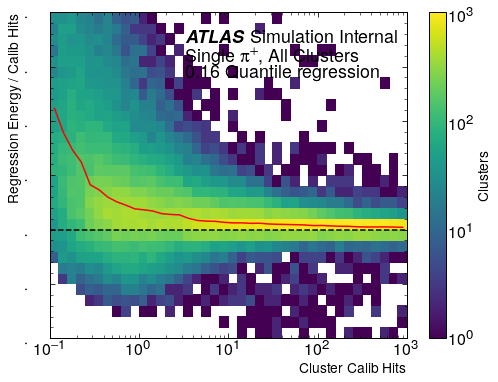

<Figure size 576x432 with 0 Axes>

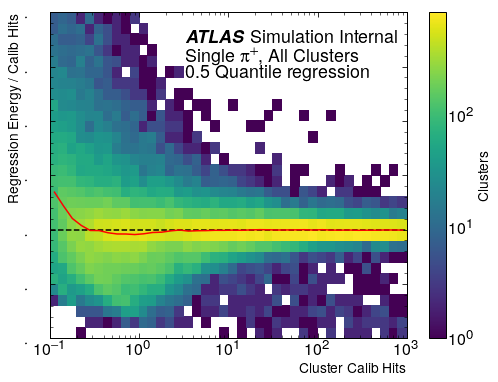

<Figure size 576x432 with 0 Axes>

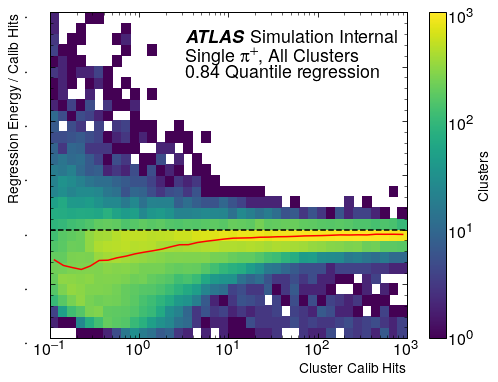

In [18]:
regQuant = []
for q in quantiles:
    xcenter, rq = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT,
                      pdata['piplus'][pdata['piplus'].test]['quantile_'+str(q)+'_EoverCalib'], 
                      figfile = plotpath+'quantile_'+str(q)+'_response.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                 {'x': 0.38, 'y': 0.8, 'text': str(q)+' Quantile regression'}])
    regQuant.append(rq)

<Figure size 576x432 with 0 Axes>

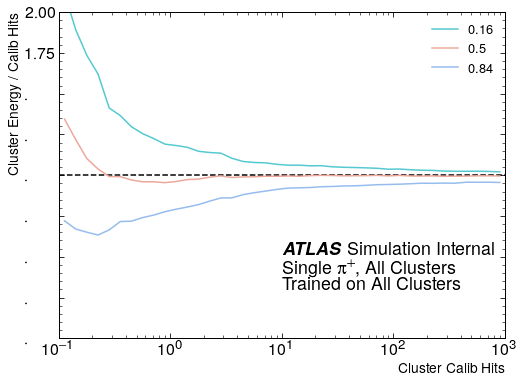

In [20]:
pu.lineOverlay(xcenter=xcenter, lines = regQuant,
                labels = [str(q) for q in quantiles],
                xlabel = 'Cluster Calib Hits', ylabel = 'Cluster Energy / Calib Hits',
                figfile = plotpath + "quantile_overlay.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}])

## Quantile Ordering

In [18]:
# seperate training set into upper/lower halves based on network's prediction
# of median energy
pdata_upper = pdata['piplus'].clusterE > pdata['piplus']['quantile_0.5']
pdata_lower = pdata['piplus'].clusterE < pdata['piplus']['quantile_0.5']

In [19]:
ordered_q = []
for q in [pdata_upper, pdata_lower]:
    def gae_model():
        number_pixels = 512 + 256 + 128 + 16 + 16 +8
        # create model
        with strategy.scope():    
            model = Sequential()
            used_pixels = number_pixels + 2
    #     if number_pixels < 128:
    #         used_pixels = 128
            model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
            # model.add(Dropout(0.2))
            model.add(Dense(used_pixels, activation='relu'))
            # model.add(Dropout(0.2))
            model.add(Dense(int(used_pixels/2), activation='relu'))
            # model.add(Dropout(0.2))
            model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
            opt = Adam(lr=1e-4, decay=1e-6)
            model.compile(optimizer=opt, loss=get_GAE(0.5),metrics=['mae','mse'])

        return model
    
    ordered_q.append(
        KerasRegressor(build_fn=gae_model, batch_size=200*ngpu, epochs=50, verbose=1)
    )


In [ ]:
# train models
for m,q in zip(ordered_q, [pdata_upper, pdata_lower]):
    history = m.fit(
        All_input['piplus'][pdata['piplus'].train & q],
        pdata['piplus'][pdata['piplus'].train & q].s_logECalib.to_numpy()
    )

In [29]:
# save models
for m, q in zip(ordered_q,[0.75,0.25]):
    m.model.save(modelpath + 'ordered_' + str(q) + '.h5')

In [20]:
# load models
for m, q in zip(ordered_q,[0.75,0.25]):
    m.model = load_model(modelpath + 'ordered_' + str(q) + '.h5',
                          custom_objects={'GAE_q':get_GAE(0.5)}
    )

In [21]:
for m, q in zip(ordered_q,[0.75,0.25]):
    pdata['piplus']['ordered_'+str(q)] = np.exp(
        scaler_cal['piplus'].inverse_transform(m.predict(All_input['piplus']))
    )
    pdata['piplus']['ordered_'+str(q)+'_EoverCalib'] = pdata['piplus']['ordered_'+str(q)] / pdata['piplus'].cluster_ENG_CALIB_TOT

435967/435967 [==============================] - 3s 7us/sample


<Figure size 576x432 with 0 Axes>

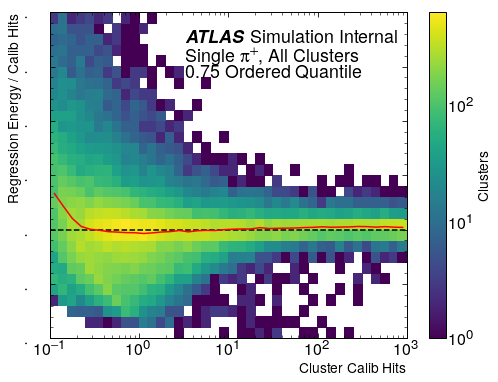

<Figure size 576x432 with 0 Axes>

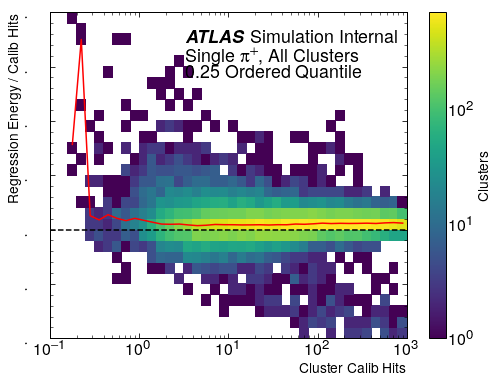

In [36]:
orderedQuant = []
for sel, q in zip([pdata_upper, pdata_lower], [0.75, 0.25]):
    xcenter, rq = ru.responsePlot(pdata['piplus'][pdata['piplus'].test & sel].cluster_ENG_CALIB_TOT,
                      pdata['piplus'][pdata['piplus'].test & sel]['ordered_'+str(q)+'_EoverCalib'], 
                      figfile = plotpath+'ordered_'+str(q)+'_response.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                 {'x': 0.38, 'y': 0.8, 'text': str(q)+' Ordered Quantile'}])
    orderedQuant.append(rq)

<Figure size 576x432 with 0 Axes>

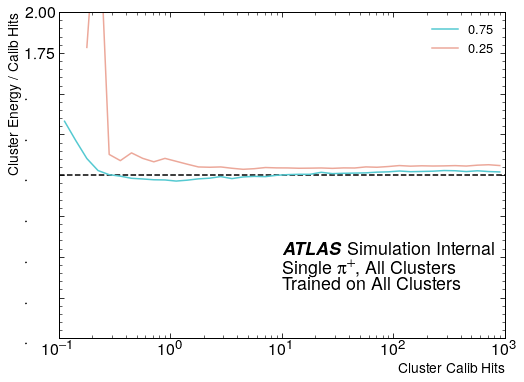

In [34]:
pu.lineOverlay(xcenter=xcenter, lines = orderedQuant,
                labels = [str(q) for q in [0.75,0.25]],
                xlabel = 'Cluster Calib Hits', ylabel = 'Cluster Energy / Calib Hits',
                figfile = plotpath + "ordered_overlay.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}])

## Comparison to baseline method for calculating IQR

In [21]:
def baseline_nn_All_model():
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels + 2
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    return model

regressor_All = KerasRegressor(build_fn=baseline_nn_All_model, batch_size=200*ngpu, epochs=100, verbose=1)
regressor_All.model = load_model(modelpath + 'all.h5')

pdata['piplus']['predict_regressor_All'] = np.exp(scaler_cal['piplus'].inverse_transform(regressor_All.predict(All_input['piplus'])))
pdata['piplus']['predict_regressor_All_EoverCalib'] = pdata['piplus'].predict_regressor_All / pdata['piplus'].cluster_ENG_CALIB_TOT

435967/435967 [==============================] - 3s 7us/sample


<Figure size 576x432 with 0 Axes>

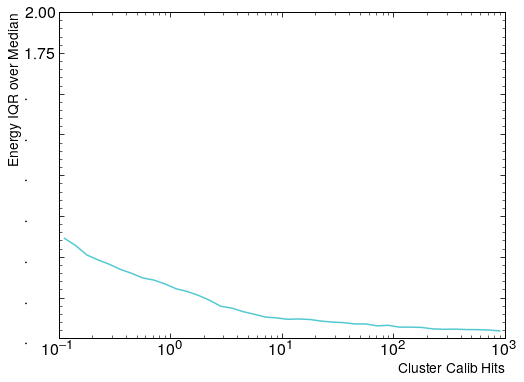

<Figure size 576x432 with 0 Axes>

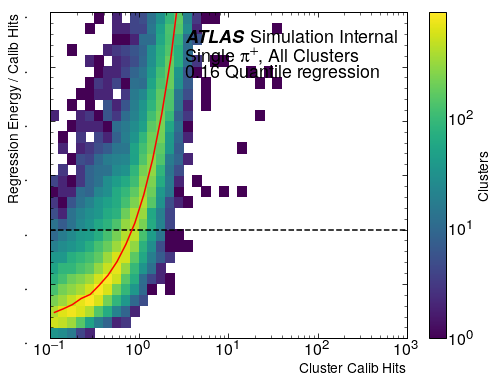

<Figure size 576x432 with 0 Axes>

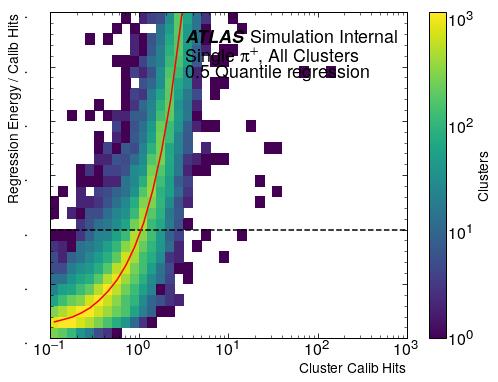

<Figure size 576x432 with 0 Axes>

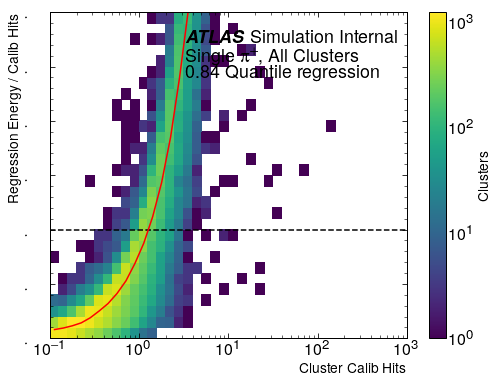

In [22]:
xcenter, iqrOverMedAll = ru.resolutionPlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT, 
                        pdata['piplus'][pdata['piplus'].test].predict_regressor_All_EoverCalib, statistic='iqrOverMed')

# xcenter, med = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT, 
#                         pdata['piplus'][pdata['piplus'].test]['quantile_0.5'], statistic='median',
#                               ylabel='Cluster Energy', figfile = plotpath + 'median_energy.pdf')

# orderedQuant_raw = []
# for sel, q in zip([pdata_upper, pdata_lower], [0.75, 0.25]):
#     xcenter, rq = ru.responsePlot(pdata['piplus'][pdata['piplus'].test & sel].cluster_ENG_CALIB_TOT,
#                       pdata['piplus'][pdata['piplus'].test & sel]['ordered_'+str(q)], 
#                       statistic = 'median',
#                       xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
#                       atlas_x = 0.38, atlas_y = 0.95, simulation = True,
#                       textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
#                                  {'x': 0.38, 'y': 0.8, 'text': str(q)+' Ordered Quantile'}])
#     orderedQuant_raw.append(rq)
    
regQuant_raw = []
for q in quantiles:
    xcenter, rq = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT,
                      pdata['piplus'][pdata['piplus'].test]['quantile_'+str(q)], 
                      statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                 {'x': 0.38, 'y': 0.8, 'text': str(q)+' Quantile regression'}])
    regQuant_raw.append(rq)

<Figure size 576x432 with 0 Axes>

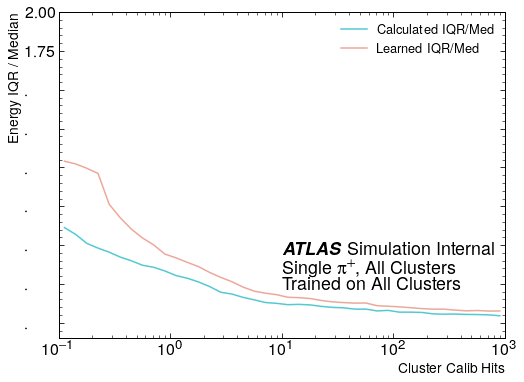

In [24]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMedAll, (regQuant_raw[0]-regQuant_raw[2])/regQuant_raw[1]],
                labels = ['Calculated IQR/Med','Learned IQR/Med'],
                xlabel = 'Cluster Calib Hits', ylabel = 'Energy IQR / Median',
                figfile = plotpath + "iqr_overlay.pdf",
                y_min=-0.1, #extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

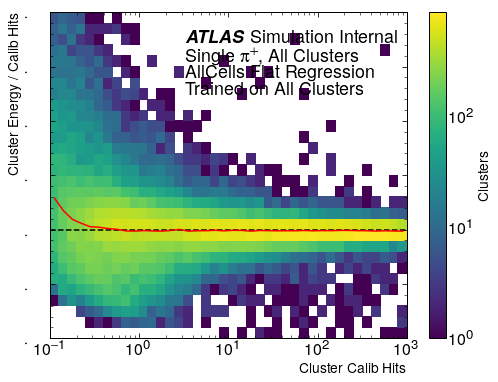

<Figure size 576x432 with 0 Axes>

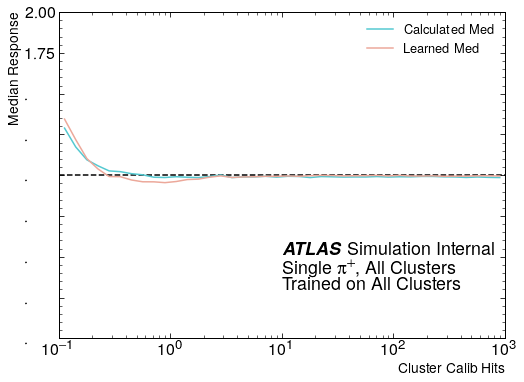

In [25]:
xcenter, medRegAll = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT, pdata['piplus'][pdata['piplus'].test].predict_regressor_All_EoverCalib,
                 statistic = 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'AllCells Flat Regression'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

pu.lineOverlay(xcenter=xcenter, lines=[medRegAll, regQuant[1]],
               labels=['Calculated Med','Learned Med'],
               xlabel = 'Cluster Calib Hits', ylabel = 'Median Response',
               figfile = plotpath + 'median_overlay.pdf',
               extra_lines = [[[0.1,1000],[1,1]]], #y_min=-0.1,
               atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}]
              )

<Figure size 576x432 with 0 Axes>

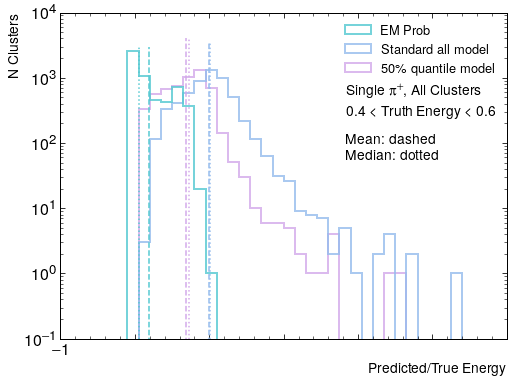

<Figure size 576x432 with 0 Axes>

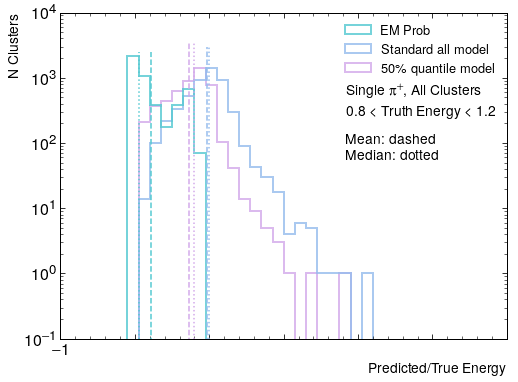

<Figure size 576x432 with 0 Axes>

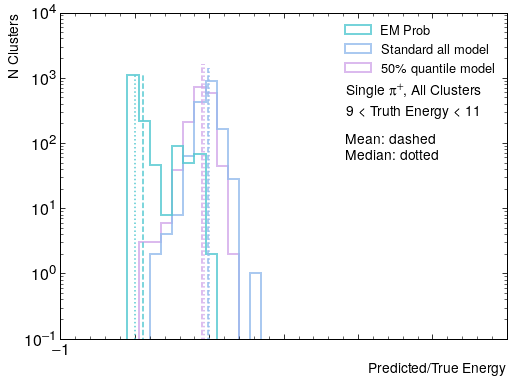

<Figure size 576x432 with 0 Axes>

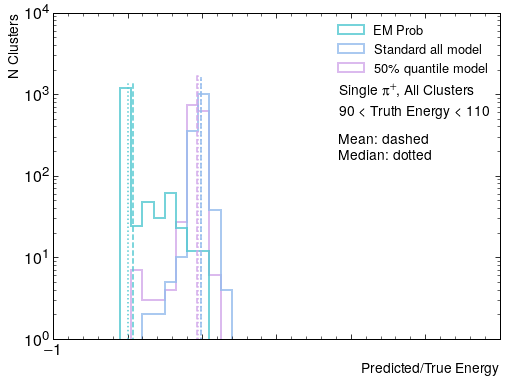

In [19]:
te_bins = [
    {'centre':0.5, 'width':0.1},
    {'centre':1, 'width':0.2},
    {'centre':10, 'width':1},
    {'centre':100, 'width':10},
]

x_min = -1
x_max = 5
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

alpha = 0.8

for i,te_bin in enumerate(te_bins):
    sel = (pdata['piplus'].cluster_ENG_CALIB_TOT >= (te_bin['centre']-te_bin['width'])) & (pdata['piplus'].cluster_ENG_CALIB_TOT < (te_bin['centre']+te_bin['width']))
    label = str(te_bin['centre']-te_bin['width'])+' < Truth Energy < '+str(te_bin['centre']+te_bin['width'])
    
    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    ax = plt.gca()
    
    data = ['cluster_EM_PROBABILITY', 'predict_regressor_All_EoverCalib', 'quantile_0.5_EoverCalib']
    labels = ['EM Prob', 'Standard all model', '50\% quantile model']
    for j,(d,l) in enumerate(zip(data,labels)):
        colour = next(ax._get_lines.prop_cycler)["color"]
        plt.hist(
            pdata['piplus'][pdata['piplus'].test & sel][d],
            bins = xbin, density = False, alpha = alpha,
            label = l, zorder=-1-j,
            facecolor="None", edgecolor=colour, lw = 2, histtype='step'
        )
        
        ymin,ymax = ax.get_ylim()
        mean = np.mean(pdata['piplus'][pdata['piplus'].test & sel][d])
        plt.plot((mean, mean), (ymin, ymax), linestyle='--', color=colour)
        
        median = np.median(pdata['piplus'][pdata['piplus'].test & sel][d])
        plt.plot((median, median), (ymin, ymax), linestyle='dotted', color=colour)
    
    plt.xlim(x_min, x_max)
    plt.yscale('log')
    ampl.set_xlabel('Predicted/True Energy')
    ampl.set_ylabel('N Clusters')
    plt.legend()
#     ampl.draw_atlas_label(0.5, 0.95, simulation='internal', fontsize=18)
    fig.axes[0].text(0.64, 0.75, "Single $\pi^{+}$, All Clusters", transform=fig.axes[0].transAxes, fontsize=14)
    fig.axes[0].text(0.64, 0.685, label, transform=fig.axes[0].transAxes, fontsize=14)
    fig.axes[0].text(0.64, 0.6, 'Mean: dashed', transform=fig.axes[0].transAxes, fontsize=14)
    fig.axes[0].text(0.64, 0.55, 'Median: dotted', transform=fig.axes[0].transAxes, fontsize=14)
    plt.savefig(plotpath+'response_overlay_bin_'+str(i)+'.pdf')
    plt.show()

## Misc IQR Studies

<Figure size 576x432 with 0 Axes>

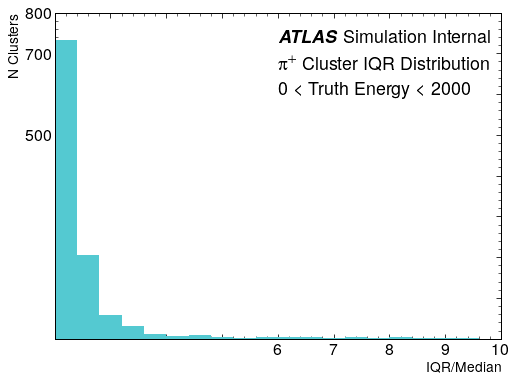

In [51]:
energy_min = 0
energy_max = 2000

x_min = 2
x_max = 10
x_bins = 20
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)
sel = (pdata['piplus'].cluster_ENG_CALIB_TOT >= energy_min) & (pdata['piplus'].cluster_ENG_CALIB_TOT < energy_max)

plt.cla()
plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist((pdata['piplus'][pdata['piplus'].test & sel]['quantile_0.16']-pdata['piplus'][pdata['piplus'].test & sel]['quantile_0.84'])/pdata['piplus'][pdata['piplus'].test]['quantile_0.5'], bins = xbin, density = False)
plt.xlim(x_min, x_max)
ampl.set_xlabel('IQR/Median')
ampl.set_ylabel('N Clusters')
ampl.draw_atlas_label(0.5, 0.95, simulation='internal', fontsize=18)
fig.axes[0].text(0.5, 0.825, "$\pi^{+}$ Cluster IQR Distribution", transform=fig.axes[0].transAxes, fontsize=18)
fig.axes[0].text(0.5, 0.75, str(energy_min)+" < Truth Energy < "+str(energy_max), transform=fig.axes[0].transAxes, fontsize=18)
plt.savefig(plotpath+'iqr_dist.pdf')
plt.show()

<Figure size 576x432 with 0 Axes>

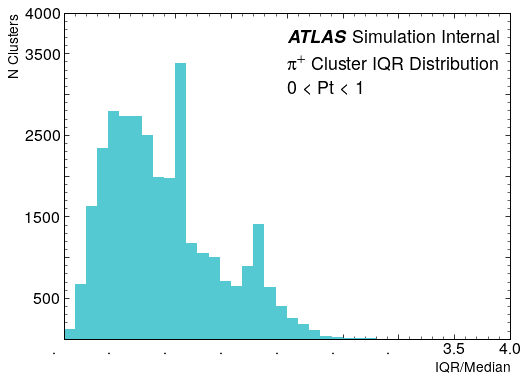

<Figure size 576x432 with 0 Axes>

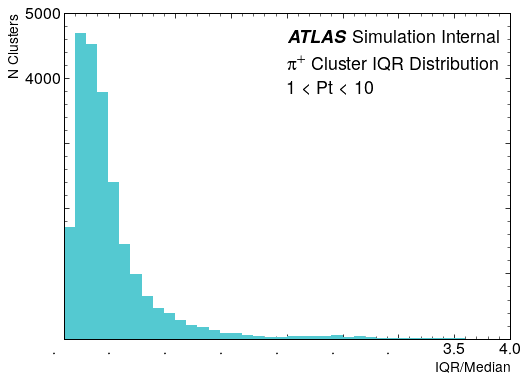

<Figure size 576x432 with 0 Axes>

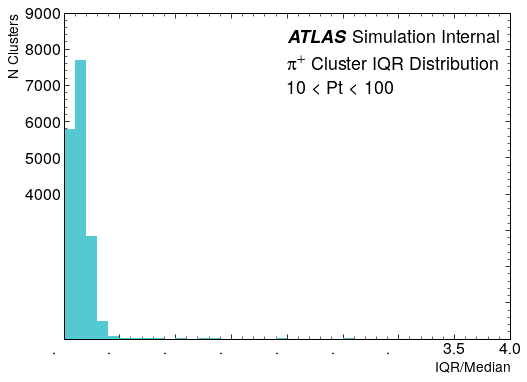

<Figure size 576x432 with 0 Axes>

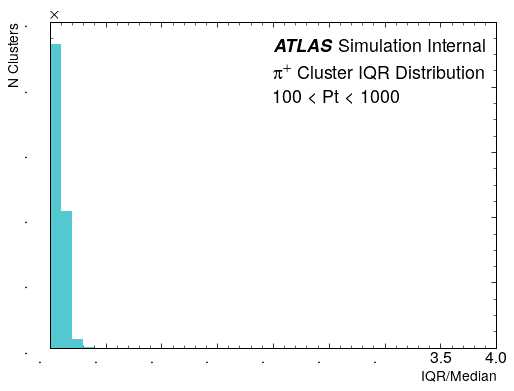

<Figure size 576x432 with 0 Axes>

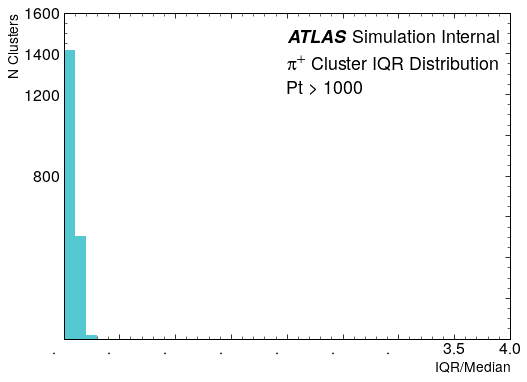

In [67]:
pt_bins = [0,1,10,100,1000]

x_min = 0
x_max = 4
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

for i in range(len(pt_bins)):
    if( i == len(pt_bins)-1 ):
        sel = pdata[ptype]['clusterPt'] > pt_bins[i]
        label = 'Pt > '+str(pt_bins[i])
    else:        
        sel = (pdata[ptype]['clusterPt'] > pt_bins[i]) & (pdata[ptype]['clusterPt'] < pt_bins[i+1])
        label = str(pt_bins[i])+' < Pt < '+str(pt_bins[i+1])

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist((pdata['piplus'][pdata['piplus'].test & sel]['quantile_0.16']-pdata['piplus'][pdata['piplus'].test & sel]['quantile_0.84'])/pdata['piplus'][pdata['piplus'].test & sel]['quantile_0.5'], bins = xbin, density = False)
    plt.xlim(x_min, x_max)
    ampl.set_xlabel('IQR/Median')
    ampl.set_ylabel('N Clusters')
    ampl.draw_atlas_label(0.5, 0.95, simulation='internal', fontsize=18)
    fig.axes[0].text(0.5, 0.825, "$\pi^{+}$ Cluster IQR Distribution", transform=fig.axes[0].transAxes, fontsize=18)
    fig.axes[0].text(0.5, 0.75, label, transform=fig.axes[0].transAxes, fontsize=18)
    plt.savefig(plotpath+'iqr_pt_'+str(i)+'_dist.pdf')
    plt.show()

<Figure size 576x432 with 0 Axes>

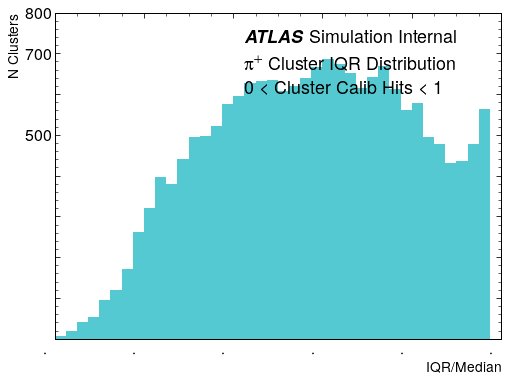

<Figure size 576x432 with 0 Axes>

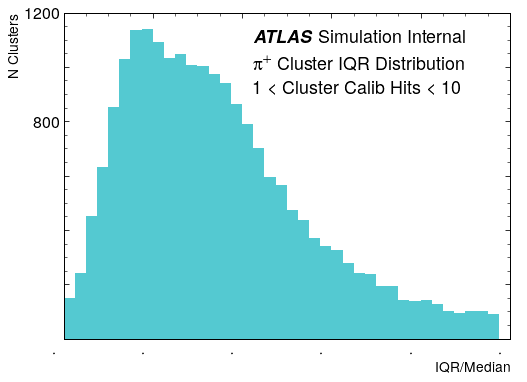

<Figure size 576x432 with 0 Axes>

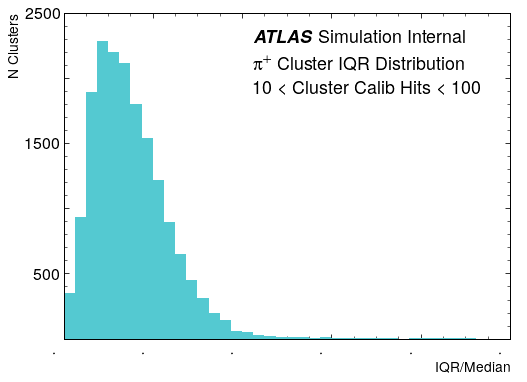

<Figure size 576x432 with 0 Axes>

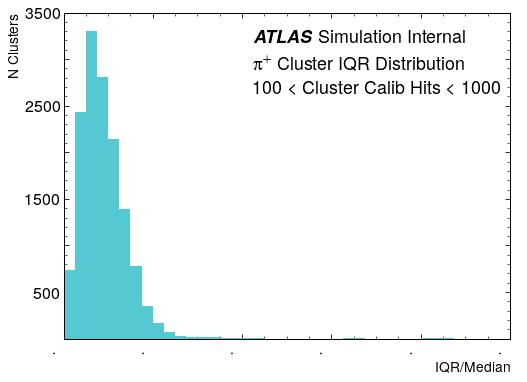

<Figure size 576x432 with 0 Axes>

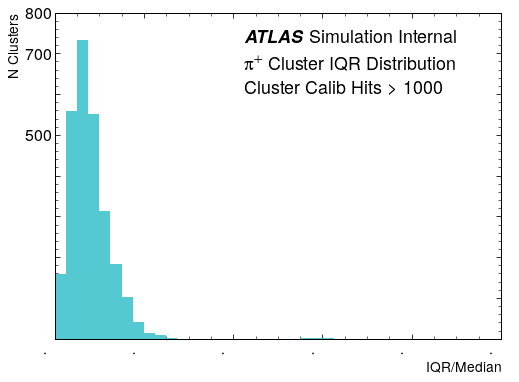

In [72]:
calib_bins = [0,1,10,100,1000]

x_min = 0
x_max = 1
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

for i in range(len(calib_bins)):
    if( i == len(calib_bins)-1 ):
        sel = pdata[ptype]['cluster_ENG_CALIB_TOT'] > calib_bins[i]
        label = 'Cluster Calib Hits > '+str(calib_bins[i])
    else:        
        sel = (pdata[ptype]['cluster_ENG_CALIB_TOT'] > calib_bins[i]) & (pdata[ptype]['cluster_ENG_CALIB_TOT'] < calib_bins[i+1])
        label = str(calib_bins[i])+' < Cluster Calib Hits < '+str(calib_bins[i+1])

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist((pdata['piplus'][pdata['piplus'].test & sel]['quantile_0.16']-pdata['piplus'][pdata['piplus'].test & sel]['quantile_0.84'])/pdata['piplus'][pdata['piplus'].test & sel]['quantile_0.5'], bins = xbin, density = False)
    plt.xlim(x_min, x_max)
    ampl.set_xlabel('IQR/Median')
    ampl.set_ylabel('N Clusters')
    ampl.draw_atlas_label(0.425, 0.95, simulation='internal', fontsize=18)
    fig.axes[0].text(0.425, 0.825, "$\pi^{+}$ Cluster IQR Distribution", transform=fig.axes[0].transAxes, fontsize=18)
    fig.axes[0].text(0.425, 0.75, label, transform=fig.axes[0].transAxes, fontsize=18)
    plt.savefig(plotpath+'iqr_calib_'+str(i)+'_dist.pdf')
    plt.show()

In [18]:
# pandas does not handle vectors in root files properly,
# so they need to be imported differently

cell_shapes = {
    'EMB1': (128,4),
    'EMB2': (16,16),
    'EMB3': (8,16),
    'TileBar0': (4,4),
    'TileBar1': (4,4),
    'TileBar2': (2,4),
}

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer)
        for layer in layers
    }
    for ifile, itree in trees.items()
}

In [19]:
# renormalise energy fractions to be per layer rather than per cluster
pcells_normed = pcells.copy()

for ptype, pcell in pcells_normed.items():
    for layer in layers:
        norms = pcell[layer].sum(axis=1)
        for i, norm in enumerate(norms):
            if( norm != 0 ):
                pcell[layer][i] = pcell[layer][i] / norm

<Figure size 576x432 with 0 Axes>

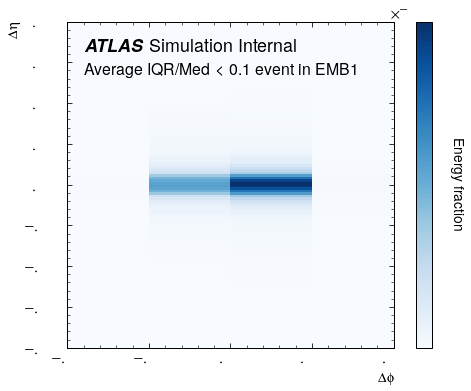

<Figure size 576x432 with 0 Axes>

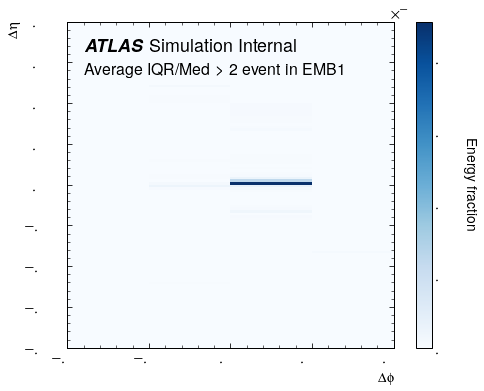

<Figure size 576x432 with 0 Axes>

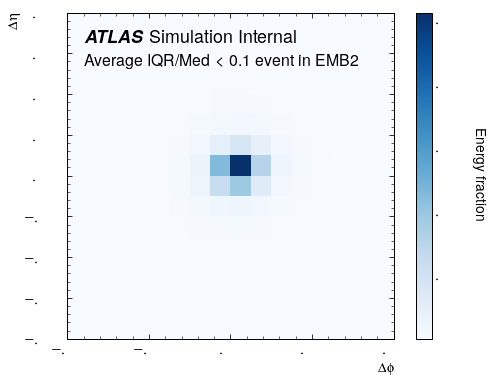

<Figure size 576x432 with 0 Axes>

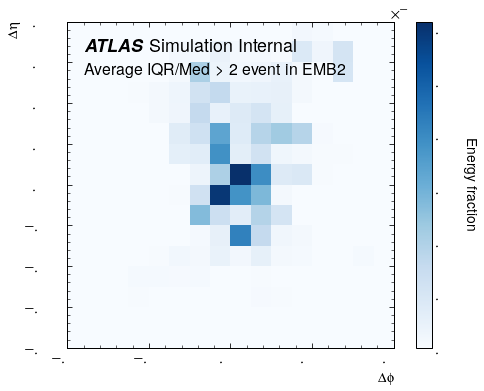

<Figure size 576x432 with 0 Axes>

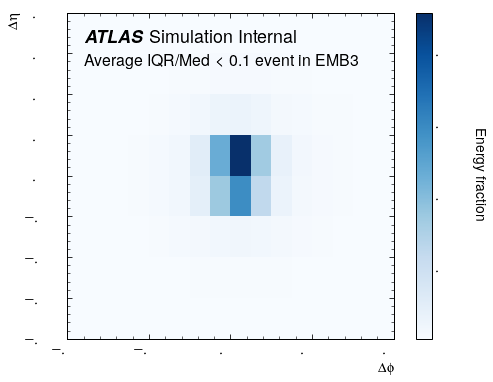

<Figure size 576x432 with 0 Axes>

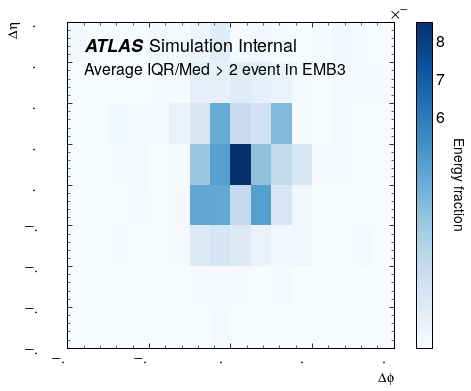

<Figure size 576x432 with 0 Axes>

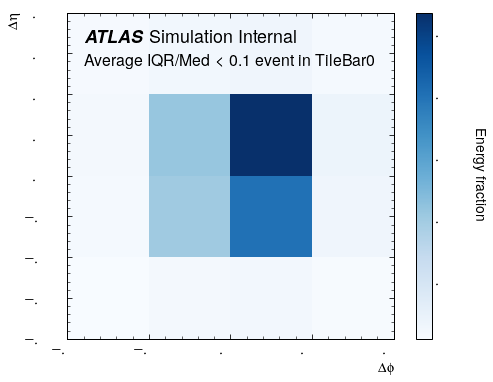

<Figure size 576x432 with 0 Axes>

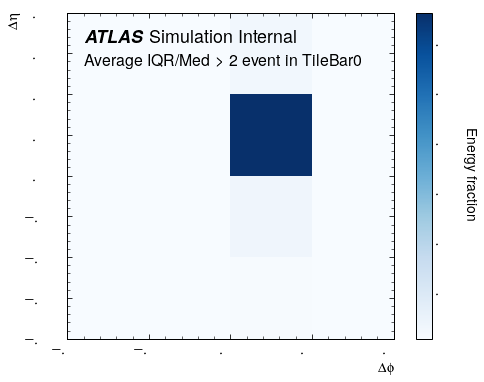

<Figure size 576x432 with 0 Axes>

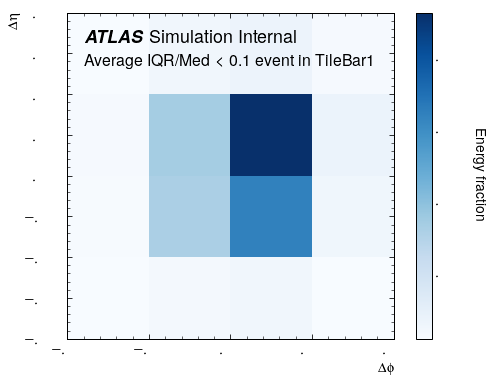

<Figure size 576x432 with 0 Axes>

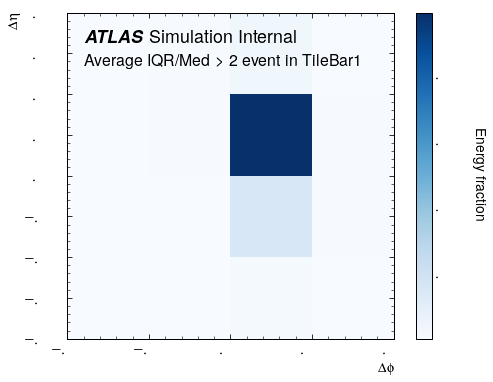

<Figure size 576x432 with 0 Axes>

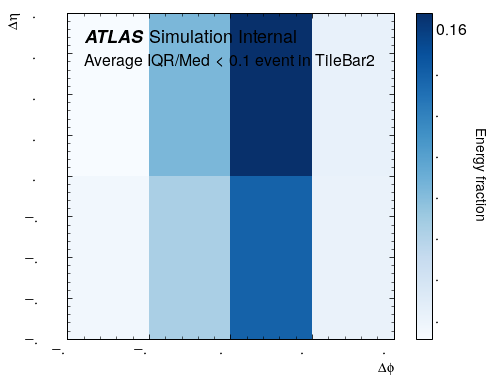

<Figure size 576x432 with 0 Axes>

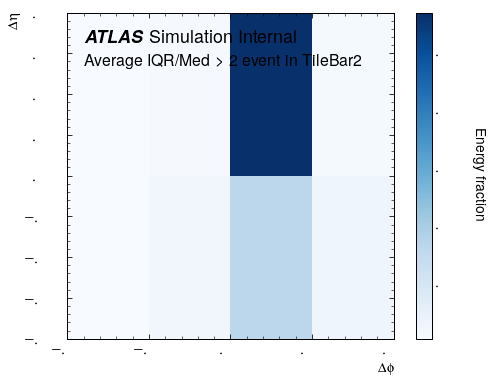

In [59]:
iqr_low = 0.1
iqr_high = 2
sel_low = (pdata['piplus']['quantile_0.16'] - pdata['piplus']['quantile_0.84'])/pdata['piplus']['quantile_0.5'] < iqr_low
sel_high = (pdata['piplus']['quantile_0.16'] - pdata['piplus']['quantile_0.84'])/pdata['piplus']['quantile_0.5'] > iqr_high

low_average = {}
high_average = {}
for layer in layers:
    low_average[layer] = pcells_normed['piplus'][layer][sel_low & pdata['piplus'].test].sum(axis=0).reshape(cell_shapes[layer]) / len(pcells_normed['piplus'][layer][sel_low & pdata['piplus'].test])
    high_average[layer] = pcells_normed['piplus'][layer][sel_high & pdata['piplus'].test].sum(axis=0).reshape(cell_shapes[layer]) / len(pcells_normed['piplus'][layer][sel_high & pdata['piplus'].test])
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    
    plt.imshow(low_average[layer], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower',
               interpolation='nearest')
    ampl.set_xlabel("$\Delta\phi$")
    ampl.set_ylabel("$\Delta\eta$")
    ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
    fig.axes[0].text(-0.18, 0.135, 'Average IQR/Med < '+str(iqr_low)+' event in '+layer)
#     fig.axes[0].text(-0.18, 0.105, label)
    cbar = plt.colorbar()
    cbar.set_label('Energy fraction', rotation=270, labelpad=20)
    plt.savefig(plotpath+'iqr_low_'+layer+'.pdf')
    plt.show()
        
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    
    plt.imshow(high_average[layer], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower',
               interpolation='nearest')
    ampl.set_xlabel("$\Delta\phi$")
    ampl.set_ylabel("$\Delta\eta$")
    ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
    fig.axes[0].text(-0.18, 0.135, 'Average IQR/Med > '+str(iqr_high)+' event in '+layer)
#     fig.axes[0].text(-0.18, 0.105, label)
    cbar = plt.colorbar()
    cbar.set_label('Energy fraction', rotation=270, labelpad=20)
    plt.savefig(plotpath+'iqr_high_'+layer+'.pdf')
    plt.show()

<Figure size 576x432 with 0 Axes>

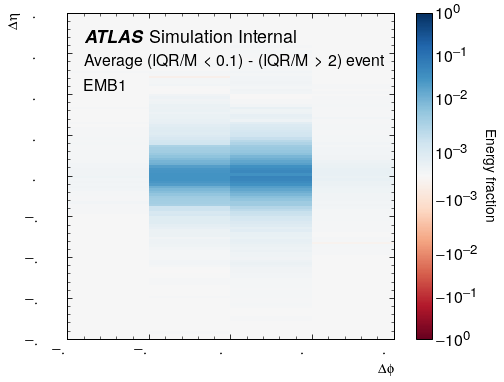

<Figure size 576x432 with 0 Axes>

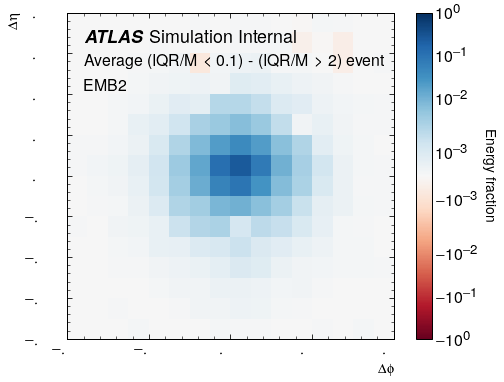

<Figure size 576x432 with 0 Axes>

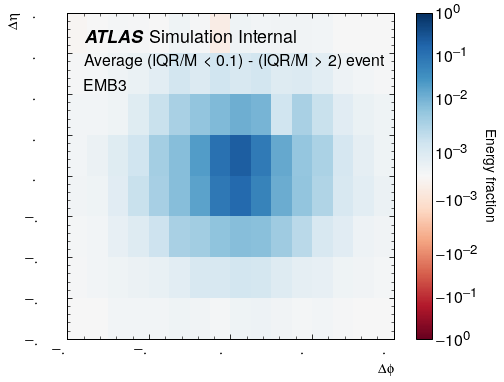

<Figure size 576x432 with 0 Axes>

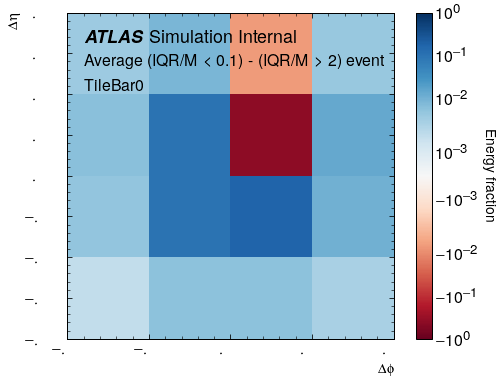

<Figure size 576x432 with 0 Axes>

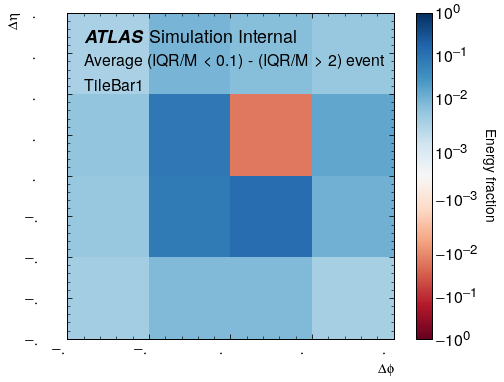

<Figure size 576x432 with 0 Axes>

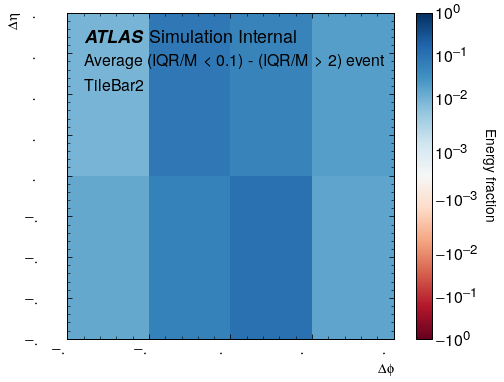

In [60]:
for layer in layers:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    
    average_diff = low_average[layer] - high_average[layer]
    plt.imshow(average_diff,
               norm=mpl.colors.SymLogNorm(linthresh=0.002, linscale=1,
                    vmin=-1.0, vmax=1.0, base=10),
               extent=[-0.2, 0.2, -0.2, 0.2],
               cmap='RdBu', origin='lower',
               interpolation='nearest')
    ampl.set_xlabel("$\Delta\phi$")
    ampl.set_ylabel("$\Delta\eta$")
    ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
    fig.axes[0].text(-0.18, 0.135, 'Average (IQR/M < '+str(iqr_low)+') - (IQR/M > '+str(iqr_high)+') event')
    fig.axes[0].text(-0.18, 0.105, layer)
    cbar = plt.colorbar()
    cbar.set_label('Energy fraction', rotation=270, labelpad=20)
    plt.savefig(plotpath+'iqr_diff_'+layer+'.pdf')
    plt.show()

<Figure size 576x432 with 0 Axes>

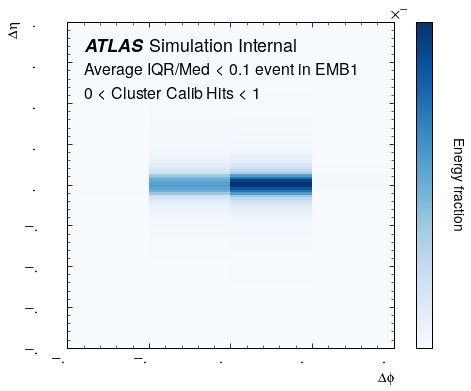

<Figure size 576x432 with 0 Axes>

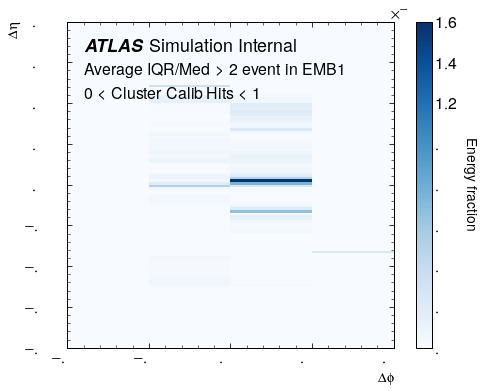

<Figure size 576x432 with 0 Axes>

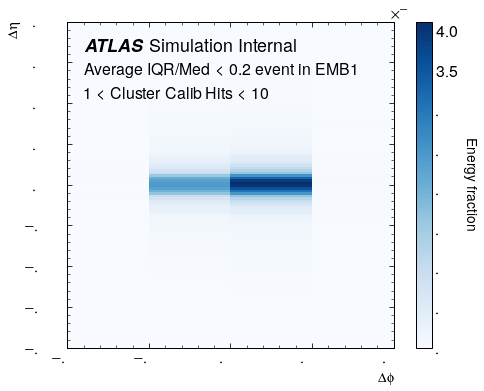

<Figure size 576x432 with 0 Axes>

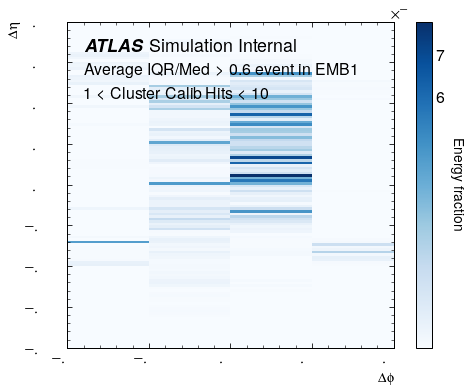

<Figure size 576x432 with 0 Axes>

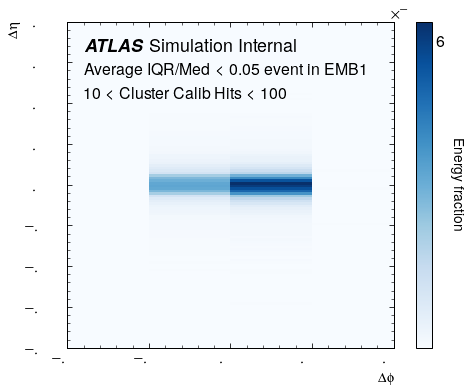

<Figure size 576x432 with 0 Axes>

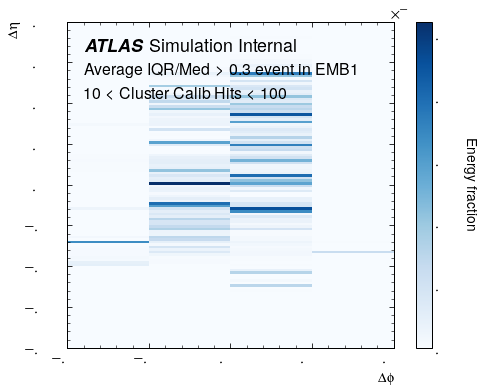

<Figure size 576x432 with 0 Axes>

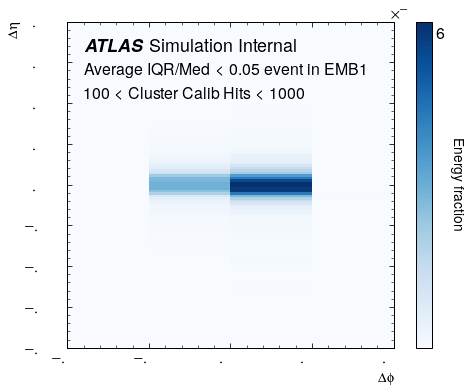

<Figure size 576x432 with 0 Axes>

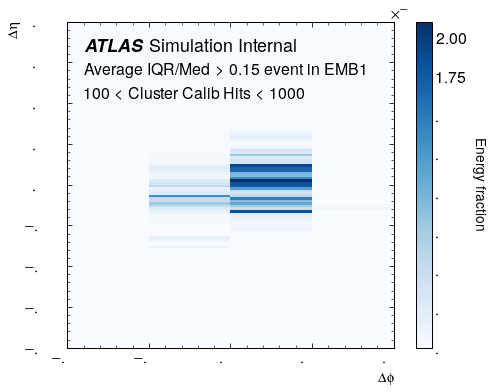

<Figure size 576x432 with 0 Axes>

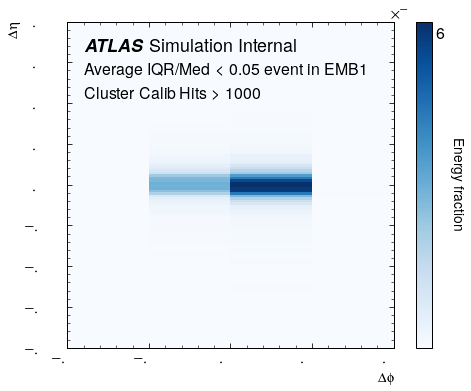

<Figure size 576x432 with 0 Axes>

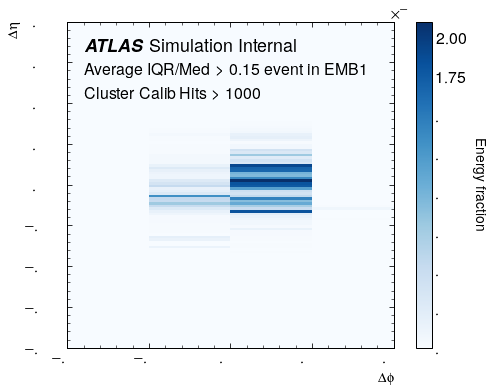

<Figure size 576x432 with 0 Axes>

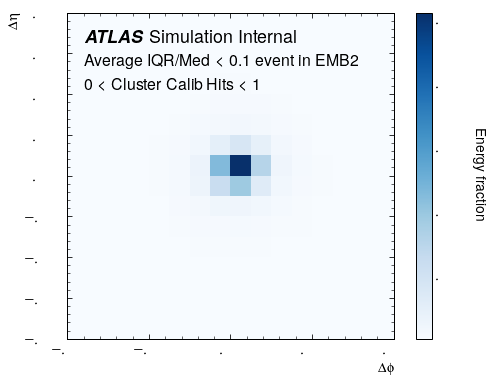

<Figure size 576x432 with 0 Axes>

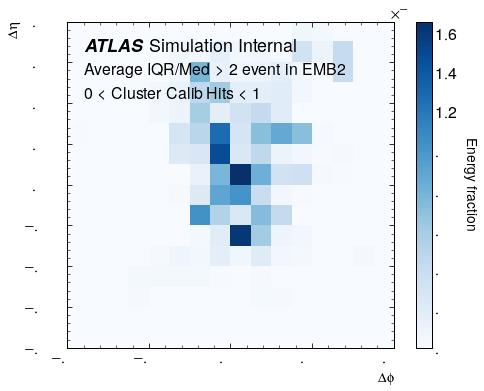

<Figure size 576x432 with 0 Axes>

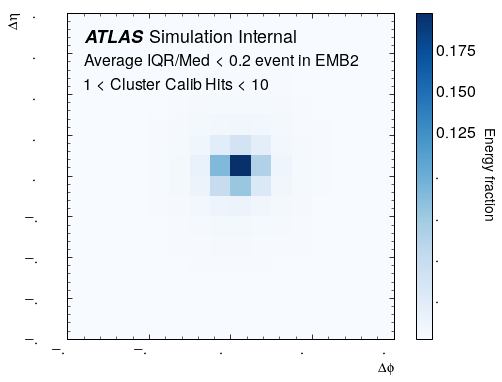

<Figure size 576x432 with 0 Axes>

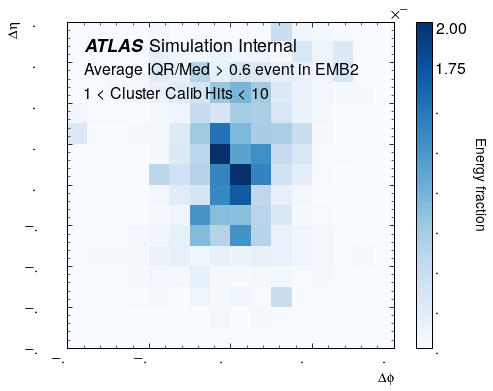

<Figure size 576x432 with 0 Axes>

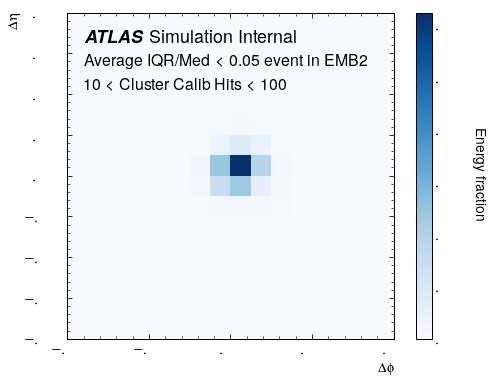

<Figure size 576x432 with 0 Axes>

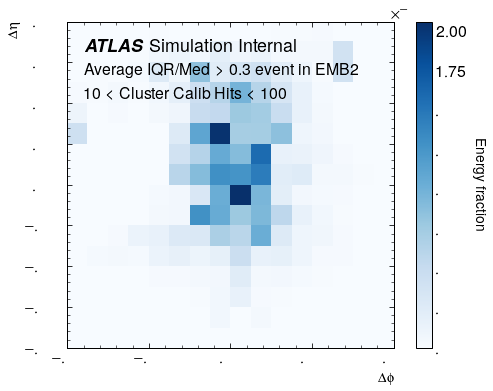

<Figure size 576x432 with 0 Axes>

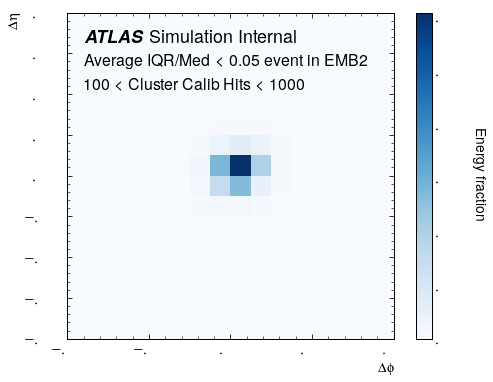

<Figure size 576x432 with 0 Axes>

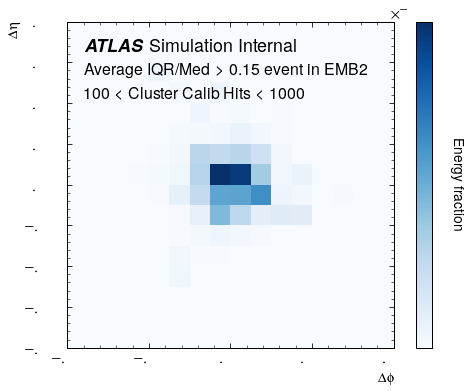

<Figure size 576x432 with 0 Axes>

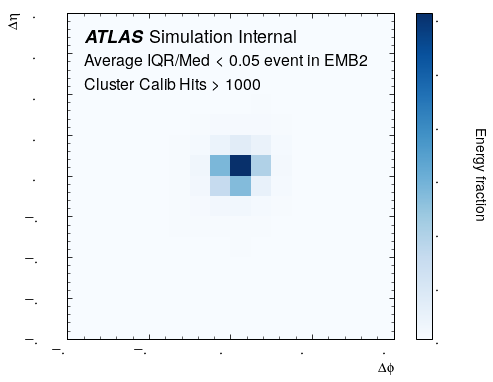

<Figure size 576x432 with 0 Axes>

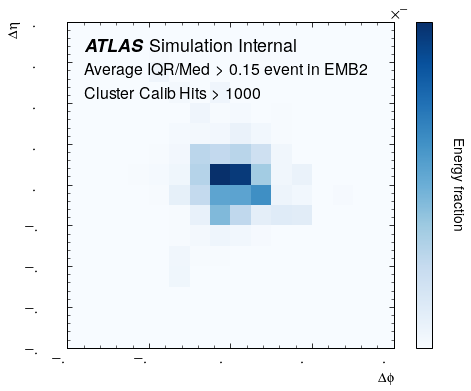

<Figure size 576x432 with 0 Axes>

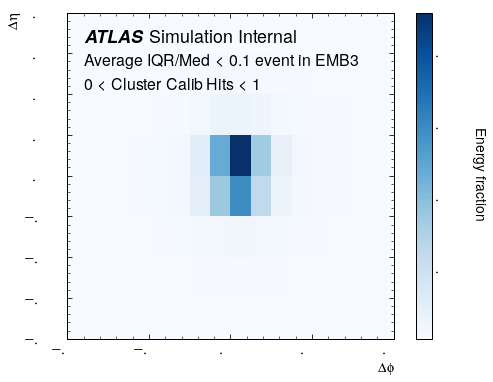

<Figure size 576x432 with 0 Axes>

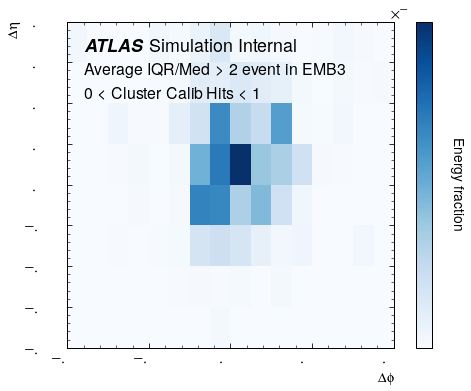

<Figure size 576x432 with 0 Axes>

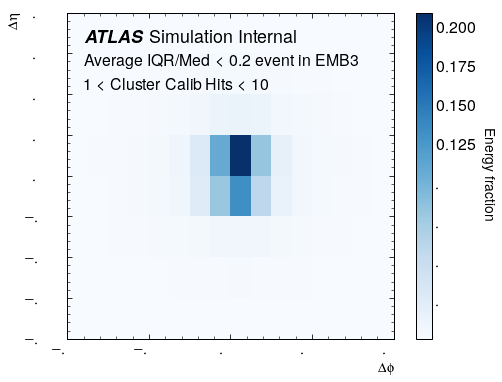

<Figure size 576x432 with 0 Axes>

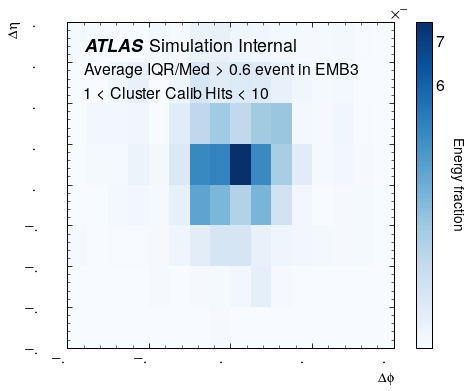

<Figure size 576x432 with 0 Axes>

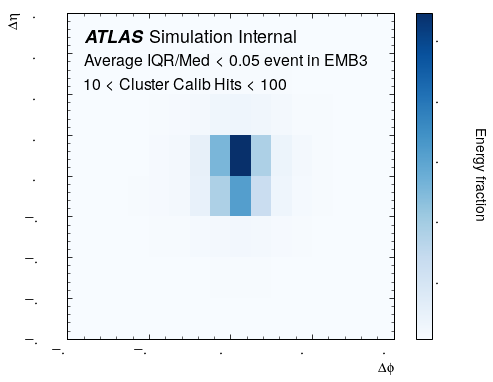

<Figure size 576x432 with 0 Axes>

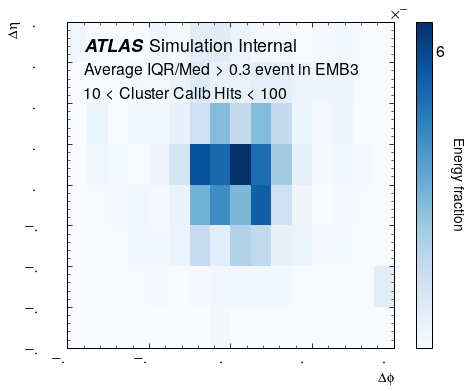

<Figure size 576x432 with 0 Axes>

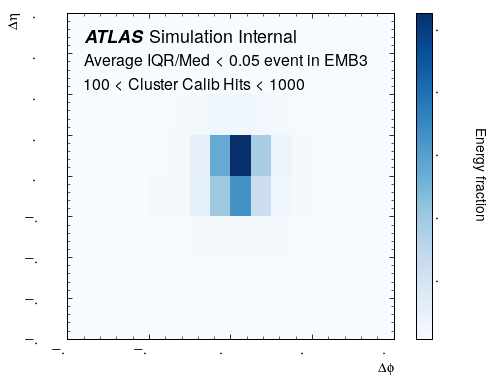

<Figure size 576x432 with 0 Axes>

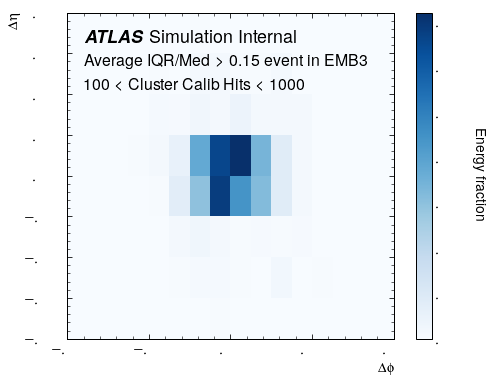

<Figure size 576x432 with 0 Axes>

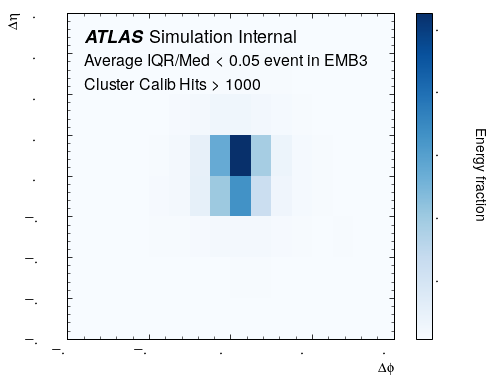

<Figure size 576x432 with 0 Axes>

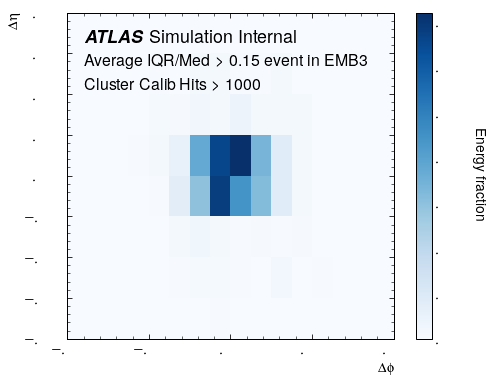

<Figure size 576x432 with 0 Axes>

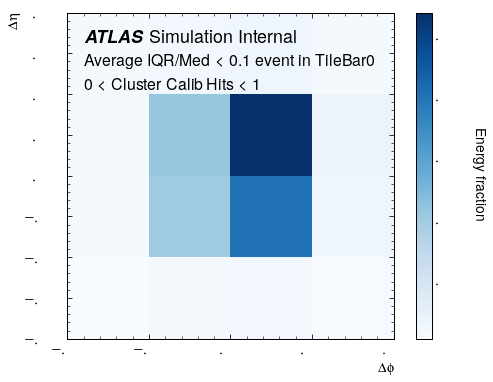

<Figure size 576x432 with 0 Axes>

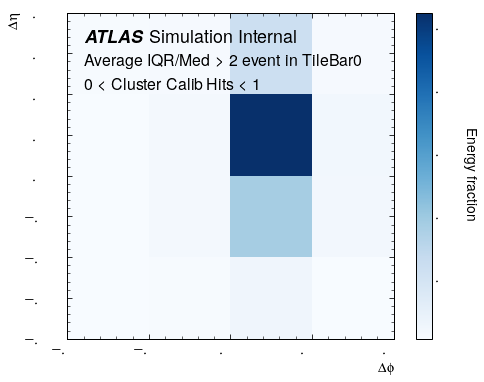

<Figure size 576x432 with 0 Axes>

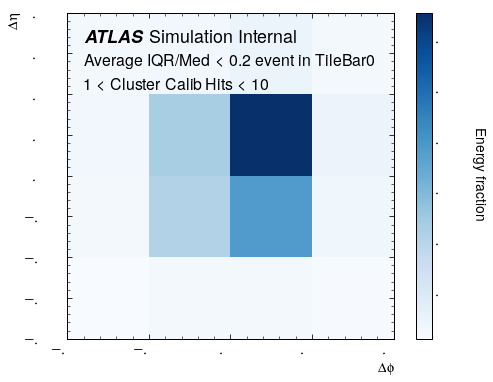

<Figure size 576x432 with 0 Axes>

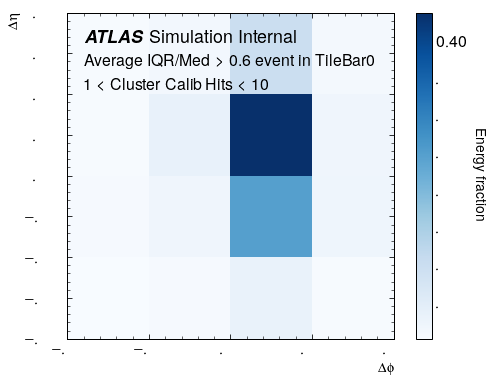

<Figure size 576x432 with 0 Axes>

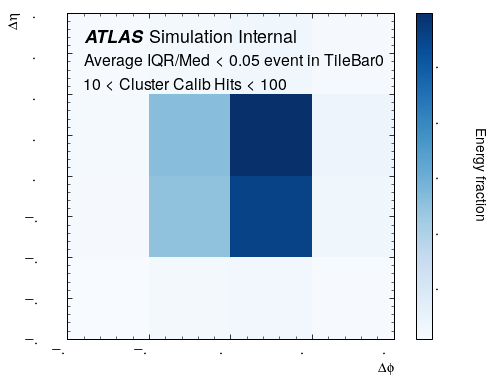

<Figure size 576x432 with 0 Axes>

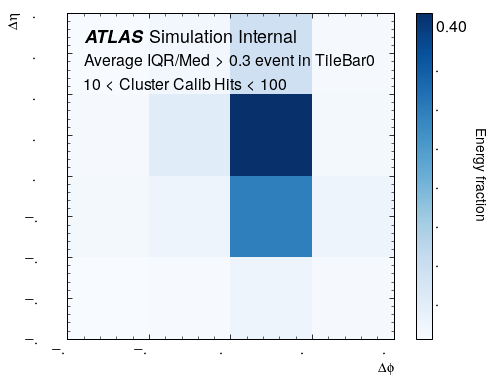

<Figure size 576x432 with 0 Axes>

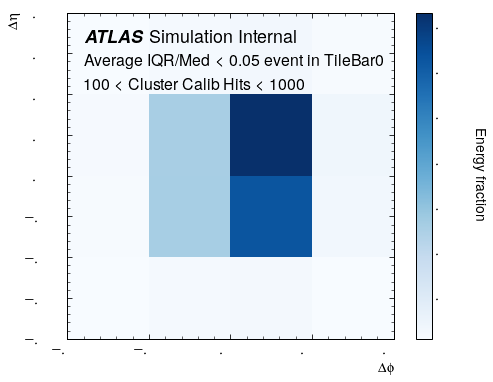

<Figure size 576x432 with 0 Axes>

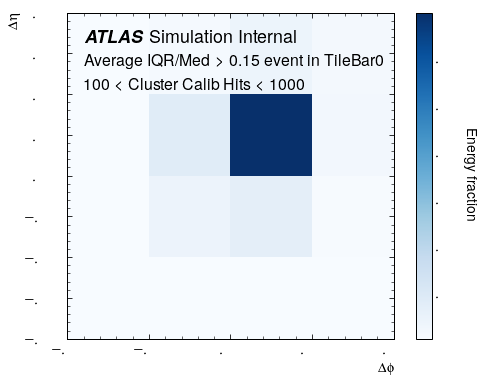

<Figure size 576x432 with 0 Axes>

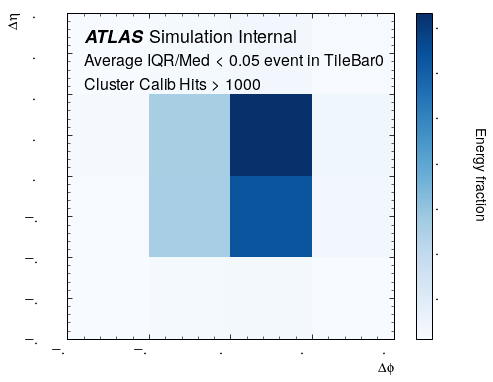

<Figure size 576x432 with 0 Axes>

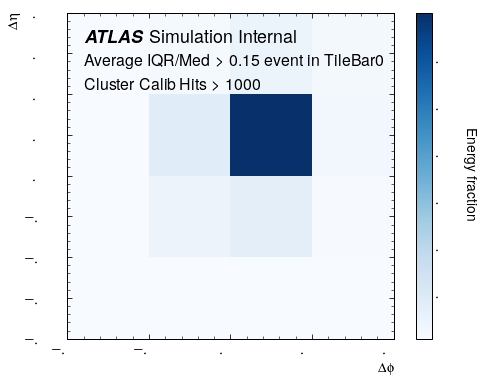

<Figure size 576x432 with 0 Axes>

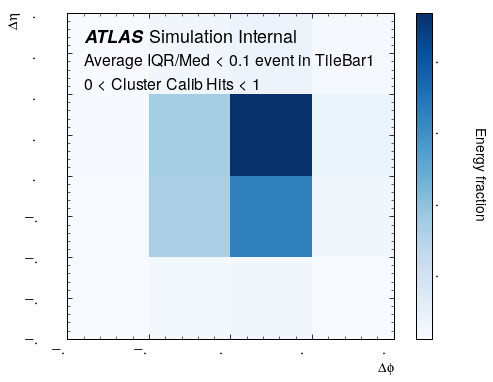

<Figure size 576x432 with 0 Axes>

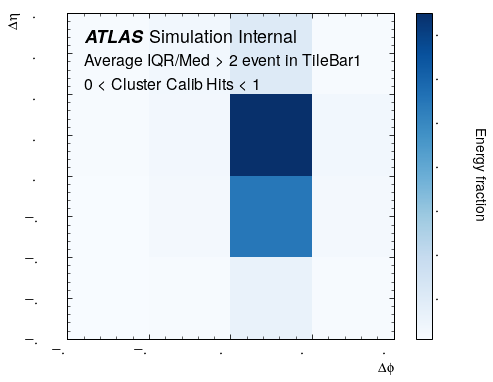

<Figure size 576x432 with 0 Axes>

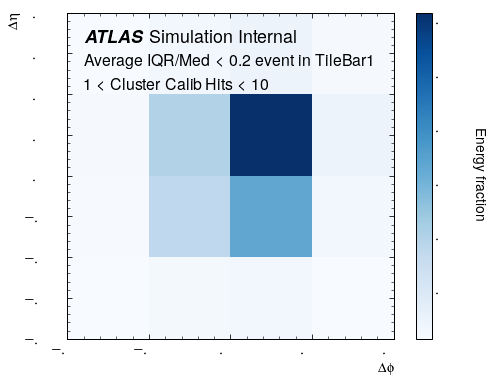

<Figure size 576x432 with 0 Axes>

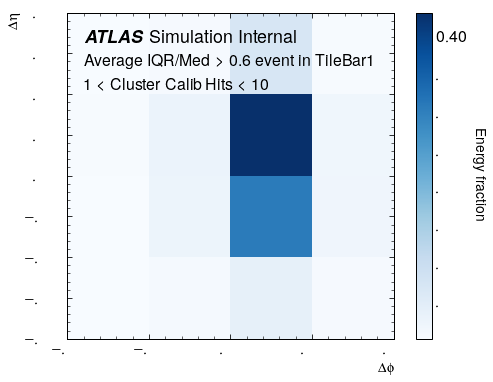

<Figure size 576x432 with 0 Axes>

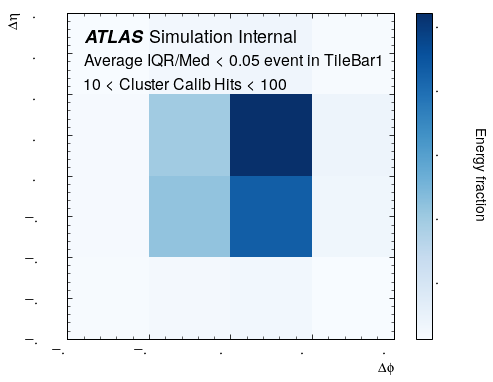

<Figure size 576x432 with 0 Axes>

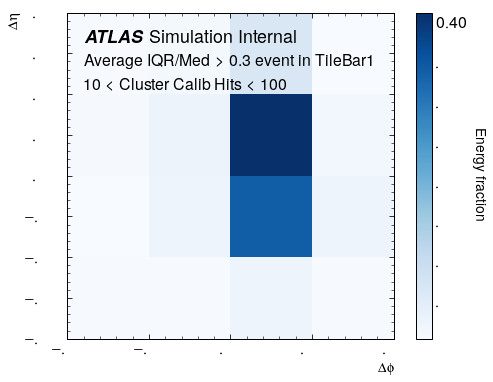

<Figure size 576x432 with 0 Axes>

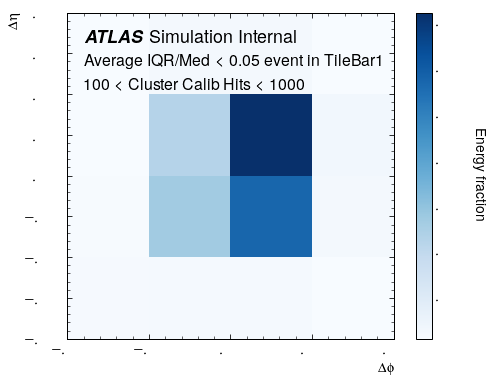

<Figure size 576x432 with 0 Axes>

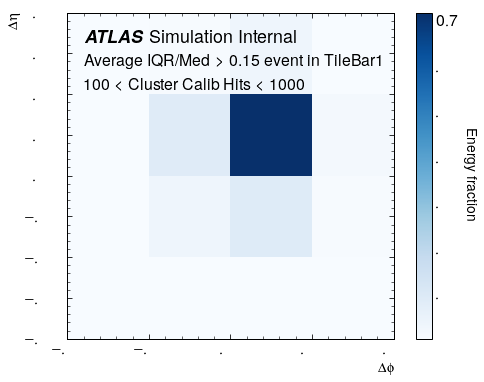

<Figure size 576x432 with 0 Axes>

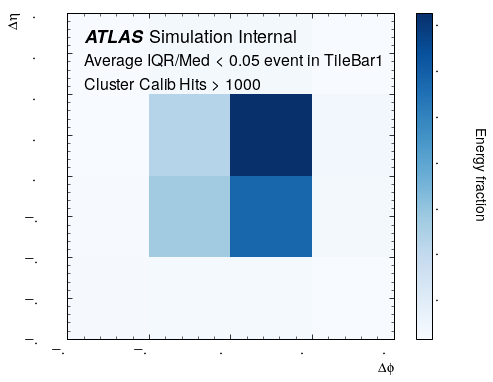

<Figure size 576x432 with 0 Axes>

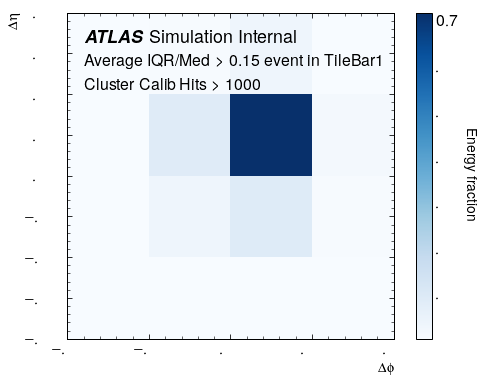

<Figure size 576x432 with 0 Axes>

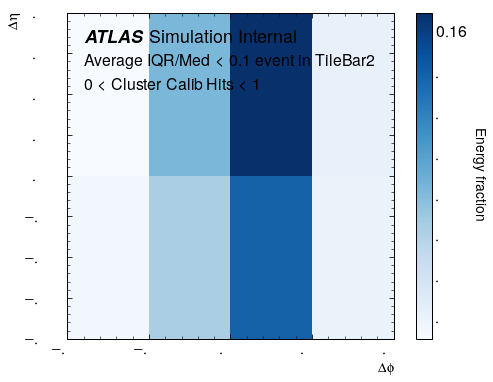

<Figure size 576x432 with 0 Axes>

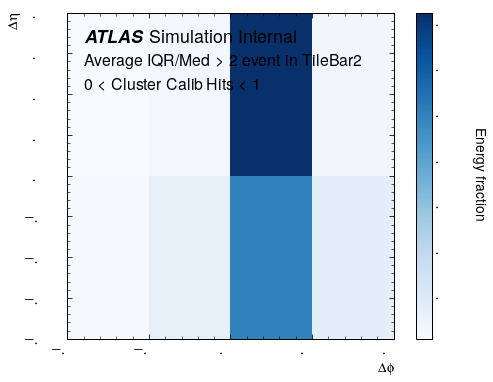

<Figure size 576x432 with 0 Axes>

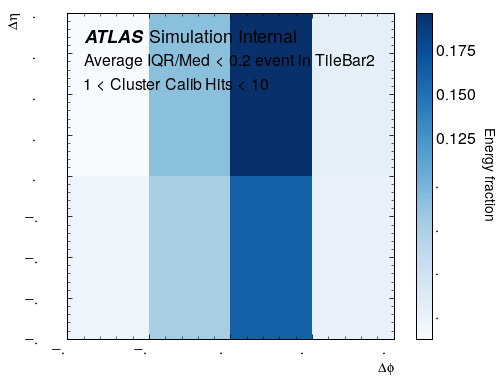

<Figure size 576x432 with 0 Axes>

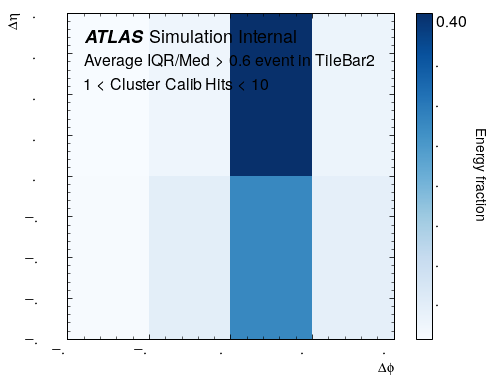

<Figure size 576x432 with 0 Axes>

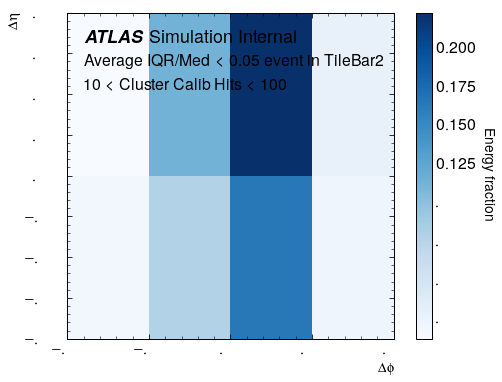

<Figure size 576x432 with 0 Axes>

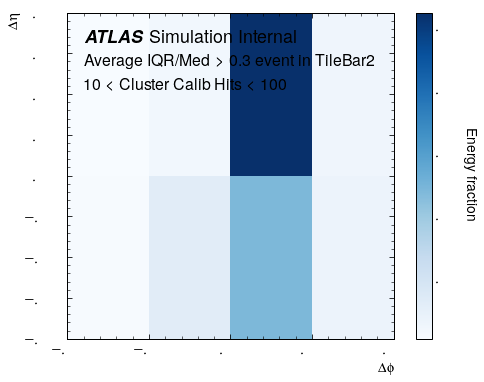

<Figure size 576x432 with 0 Axes>

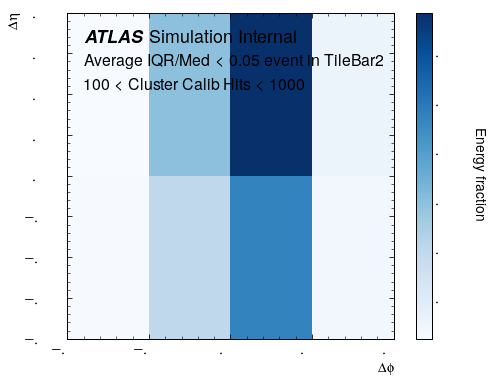

<Figure size 576x432 with 0 Axes>

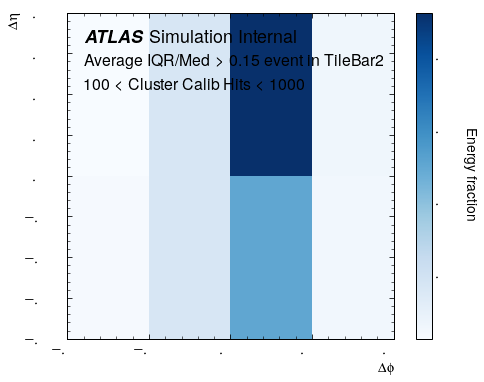

<Figure size 576x432 with 0 Axes>

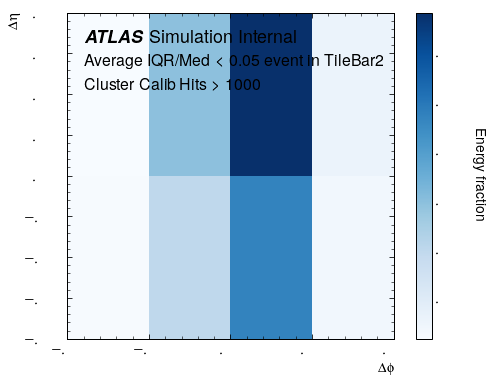

<Figure size 576x432 with 0 Axes>

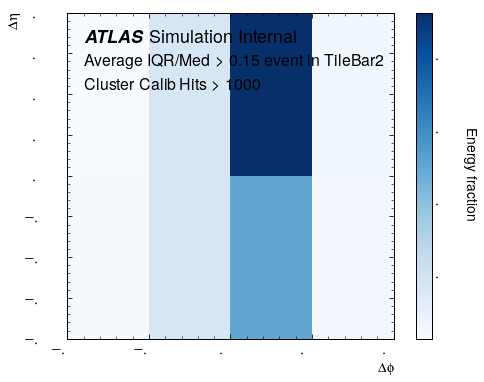

In [21]:
energy_bins = [0,1,10,100,1000]

iqr_low = [0.1,0.2,0.05,0.05,0.05]
iqr_high = [2,0.6,0.3,0.15,0.15]

low_average_binned = {}
high_average_binned = {}
for layer in layers:
    low_average_binned[layer] = []
    high_average_binned[layer] = []
    for i in range(len(energy_bins)):
        sel_low = (pdata['piplus']['quantile_0.16'] - pdata['piplus']['quantile_0.84'])/pdata['piplus']['quantile_0.5'] < iqr_low[i]
        sel_high = (pdata['piplus']['quantile_0.16'] - pdata['piplus']['quantile_0.84'])/pdata['piplus']['quantile_0.5'] > iqr_high[i]

        if( i == len(energy_bins)-1 ):
            label = 'Cluster Calib Hits > '+str(energy_bins[i])
            sel_energy = pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]
        else:
            label = str(energy_bins[i])+' < Cluster Calib Hits < '+str(energy_bins[i+1])
            sel_energy = (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i+1])
        
        n_evt = len(pcells_normed['piplus'][layer][sel_energy & sel_low & pdata['piplus'].test])
        low_average_binned[layer].append(
            pcells_normed['piplus'][layer][sel_energy & sel_low & pdata['piplus'].test].sum(axis=0).reshape(cell_shapes[layer]) / max(n_evt,1)
        )
        n_evt = len(pcells_normed['piplus'][layer][sel_energy & sel_high & pdata['piplus'].test])
        high_average_binned[layer].append(
            pcells_normed['piplus'][layer][sel_energy & sel_high & pdata['piplus'].test].sum(axis=0).reshape(cell_shapes[layer]) / max(n_evt,1)
        )

        plt.cla(); plt.clf()
        fig = plt.figure()
        fig.patch.set_facecolor('white')

        plt.imshow(low_average_binned[layer][i], extent=[-0.2, 0.2, -0.2, 0.2],
                   cmap=plt.get_cmap('Blues'), origin='lower',
                   interpolation='nearest')
        ampl.set_xlabel("$\Delta\phi$")
        ampl.set_ylabel("$\Delta\eta$")
        ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
        fig.axes[0].text(-0.18, 0.135, 'Average IQR/Med < '+str(iqr_low[i])+' event in '+layer)
        fig.axes[0].text(-0.18, 0.105, label)
        cbar = plt.colorbar()
        cbar.set_label('Energy fraction', rotation=270, labelpad=20)
        plt.savefig(plotpath+'iqr_binned_low_'+layer+'_'+str(i)+'.pdf')
        plt.show()

        plt.cla(); plt.clf()
        fig = plt.figure()
        fig.patch.set_facecolor('white')

        plt.imshow(high_average_binned[layer][i], extent=[-0.2, 0.2, -0.2, 0.2],
                   cmap=plt.get_cmap('Blues'), origin='lower',
                   interpolation='nearest')
        ampl.set_xlabel("$\Delta\phi$")
        ampl.set_ylabel("$\Delta\eta$")
        ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
        fig.axes[0].text(-0.18, 0.135, 'Average IQR/Med > '+str(iqr_high[i])+' event in '+layer)
        fig.axes[0].text(-0.18, 0.105, label)
        cbar = plt.colorbar()
        cbar.set_label('Energy fraction', rotation=270, labelpad=20)
        plt.savefig(plotpath+'iqr_binned_high_'+layer+'_'+str(i)+'.pdf')
        plt.show()

<Figure size 576x432 with 0 Axes>

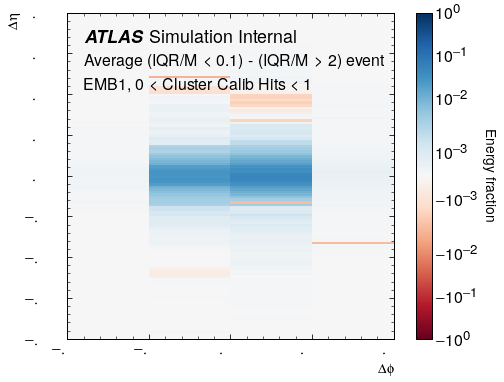

<Figure size 576x432 with 0 Axes>

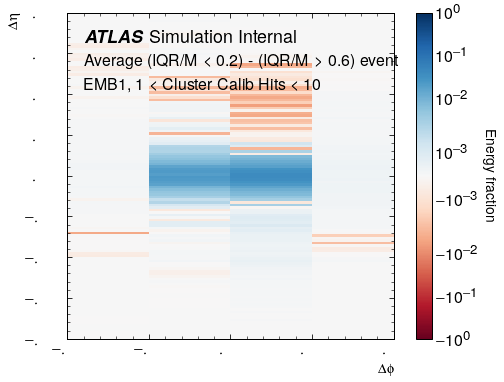

<Figure size 576x432 with 0 Axes>

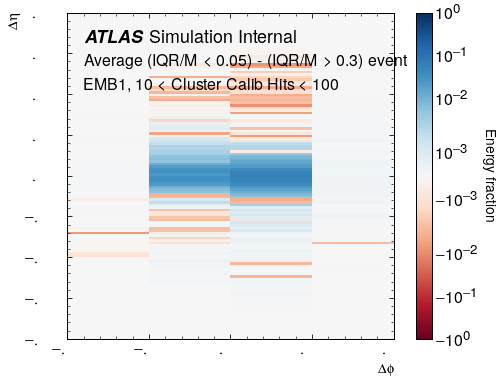

<Figure size 576x432 with 0 Axes>

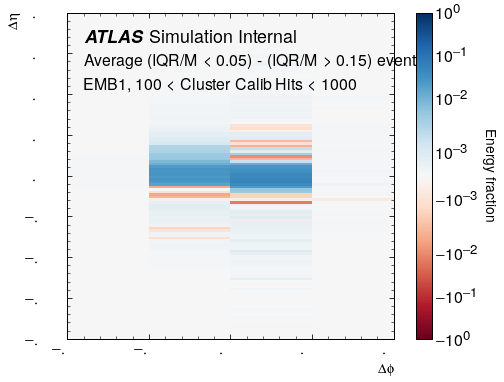

<Figure size 576x432 with 0 Axes>

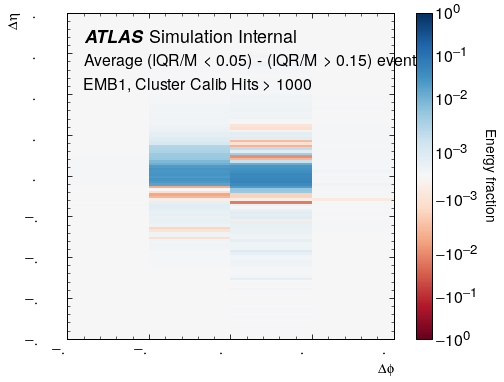

<Figure size 576x432 with 0 Axes>

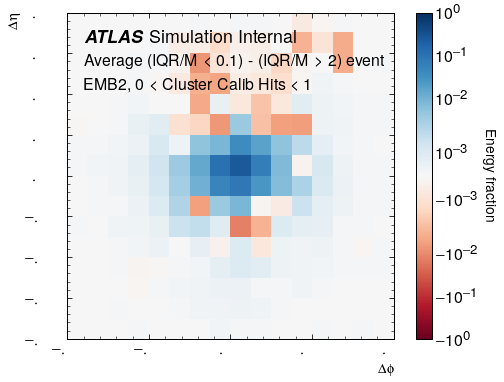

<Figure size 576x432 with 0 Axes>

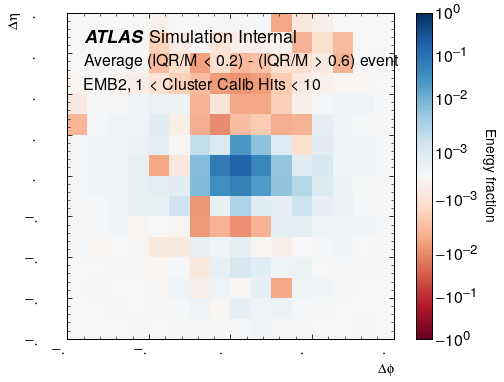

<Figure size 576x432 with 0 Axes>

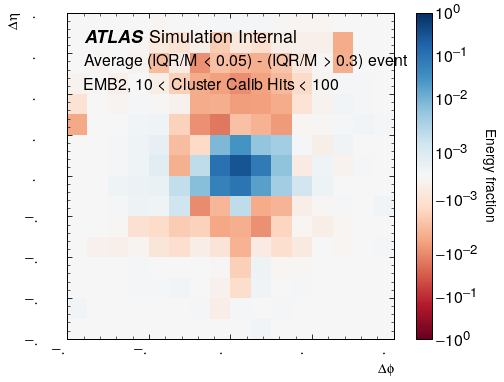

<Figure size 576x432 with 0 Axes>

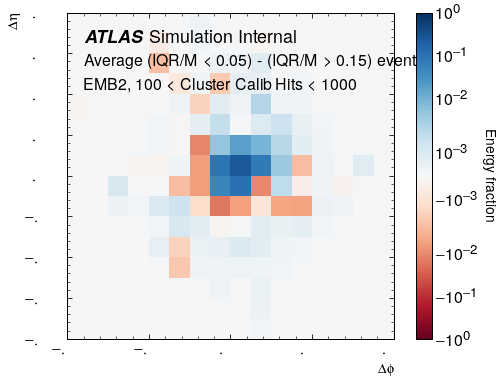

<Figure size 576x432 with 0 Axes>

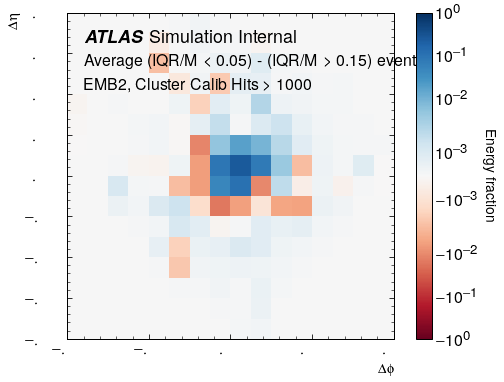

<Figure size 576x432 with 0 Axes>

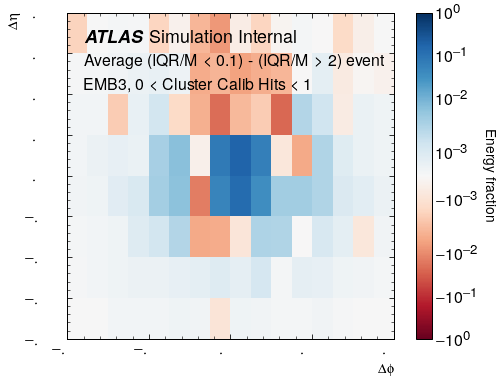

<Figure size 576x432 with 0 Axes>

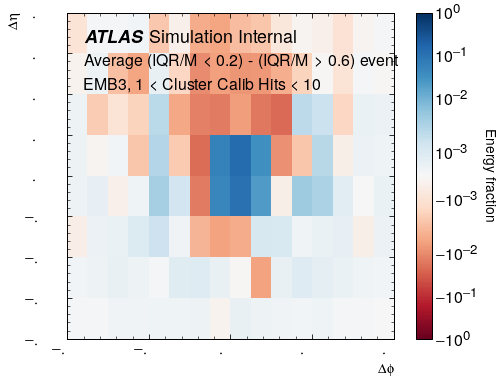

<Figure size 576x432 with 0 Axes>

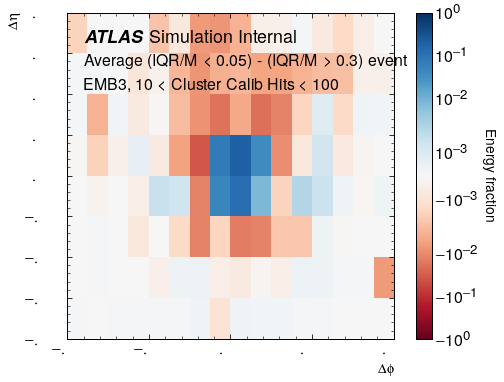

<Figure size 576x432 with 0 Axes>

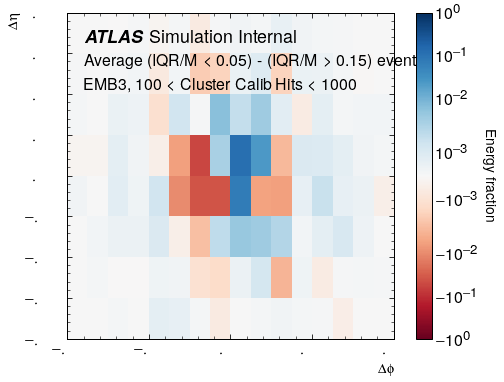

<Figure size 576x432 with 0 Axes>

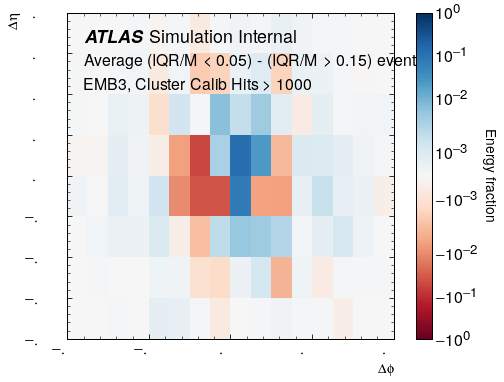

<Figure size 576x432 with 0 Axes>

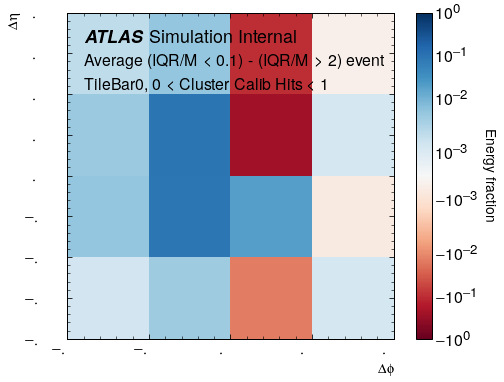

<Figure size 576x432 with 0 Axes>

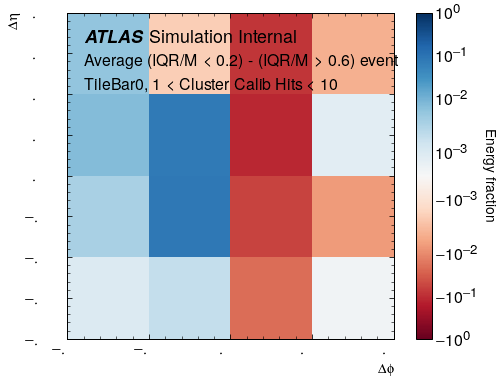

<Figure size 576x432 with 0 Axes>

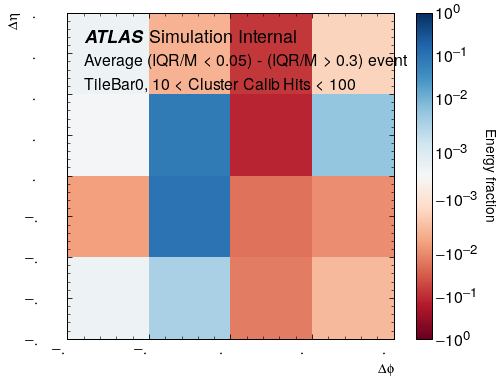

<Figure size 576x432 with 0 Axes>

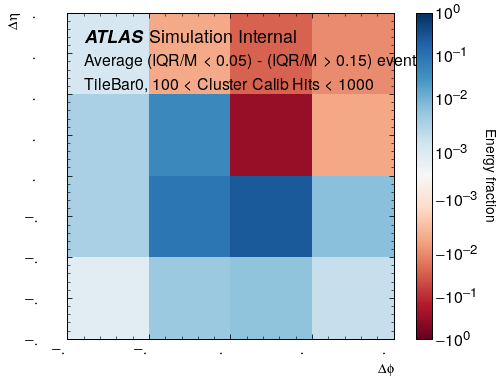

<Figure size 576x432 with 0 Axes>

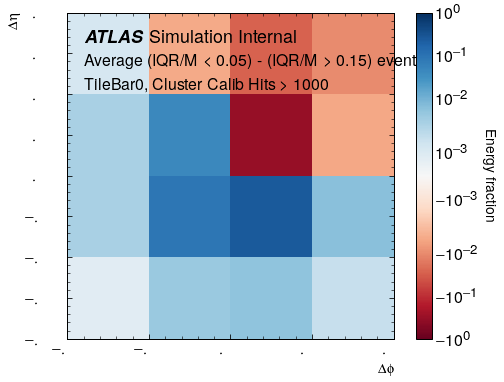

<Figure size 576x432 with 0 Axes>

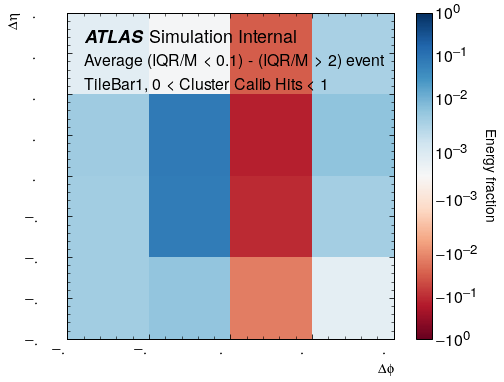

<Figure size 576x432 with 0 Axes>

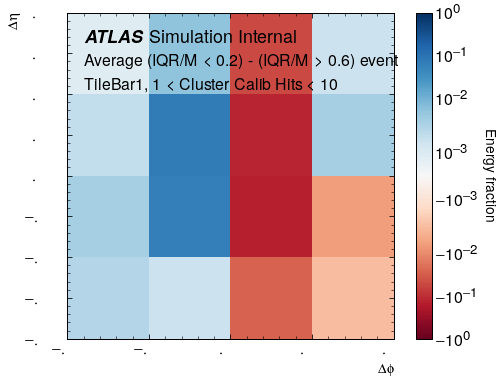

<Figure size 576x432 with 0 Axes>

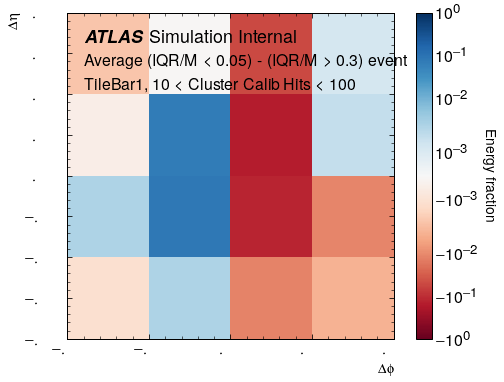

<Figure size 576x432 with 0 Axes>

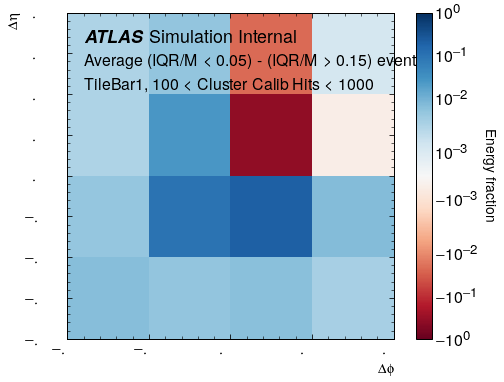

<Figure size 576x432 with 0 Axes>

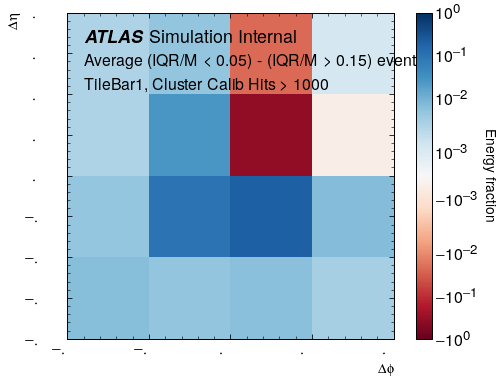

<Figure size 576x432 with 0 Axes>

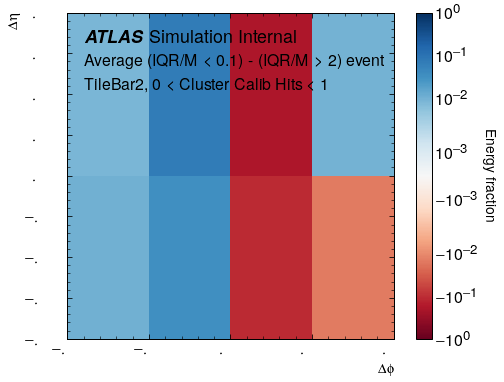

<Figure size 576x432 with 0 Axes>

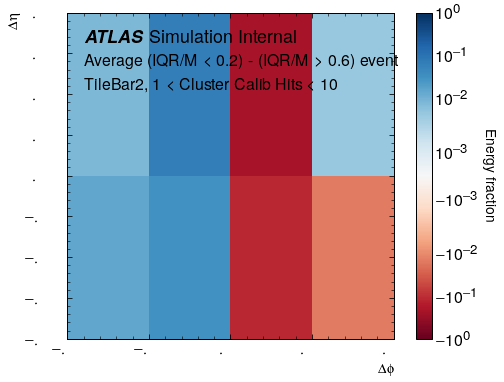

<Figure size 576x432 with 0 Axes>

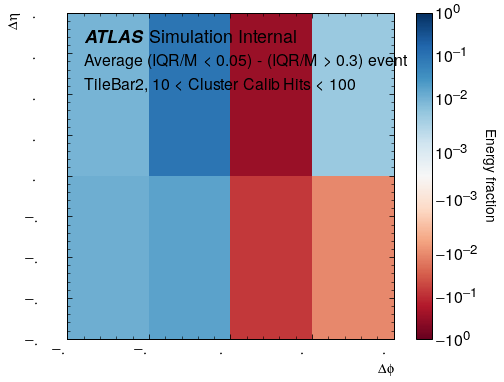

<Figure size 576x432 with 0 Axes>

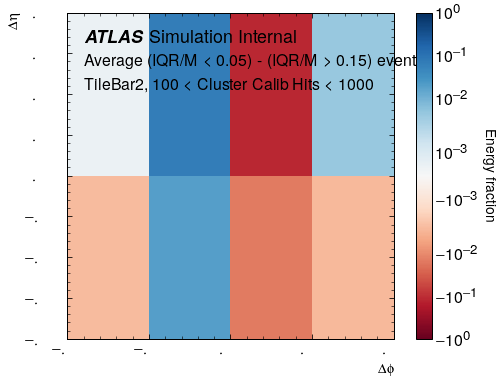

<Figure size 576x432 with 0 Axes>

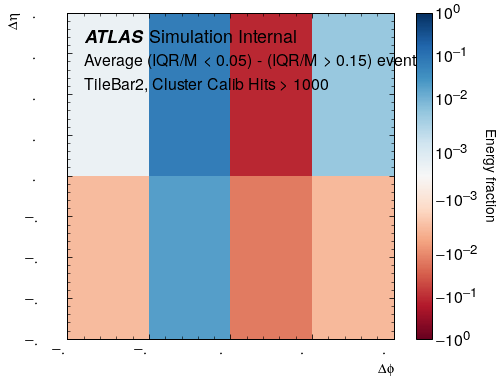

In [22]:
for layer in layers:
    for i in range(len(energy_bins)):
        if( i == len(energy_bins)-1 ):
            label = 'Cluster Calib Hits > '+str(energy_bins[i])
        else:
            label = str(energy_bins[i])+' < Cluster Calib Hits < '+str(energy_bins[i+1])

        plt.cla(); plt.clf()
        fig = plt.figure()
        fig.patch.set_facecolor('white')

        average_diff = low_average_binned[layer][i] - high_average_binned[layer][i]
        plt.imshow(average_diff,
                   norm=mpl.colors.SymLogNorm(linthresh=0.002, linscale=1,
                        vmin=-1.0, vmax=1.0, base=10),
                   extent=[-0.2, 0.2, -0.2, 0.2],
                   cmap='RdBu', origin='lower',
                   interpolation='nearest')
        ampl.set_xlabel("$\Delta\phi$")
        ampl.set_ylabel("$\Delta\eta$")
        ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
        fig.axes[0].text(-0.18, 0.135, 'Average (IQR/M < '+str(iqr_low[i])+') - (IQR/M > '+str(iqr_high[i])+') event')
        fig.axes[0].text(-0.18, 0.105, layer+", "+label)
        cbar = plt.colorbar()
        cbar.set_label('Energy fraction', rotation=270, labelpad=20)
        plt.savefig(plotpath+'iqr_binned_diff_'+layer+'_'+str(i)+'.pdf')
        plt.show()

## IQR Accuracy Study

In [21]:
# proportion of data within IQR
sel = (pdata['piplus']['quantile_0.84'] < pdata['piplus']['cluster_ENG_CALIB_TOT'])\
    & (pdata['piplus']['cluster_ENG_CALIB_TOT'] < pdata['piplus']['quantile_0.16'])
n_iqr = len(pdata['piplus']['cluster_ENG_CALIB_TOT'][sel & pdata['piplus'].test])
float(n_iqr) / len(pdata['piplus']['cluster_ENG_CALIB_TOT'][pdata['piplus'].test])

0.6844930212287683

No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

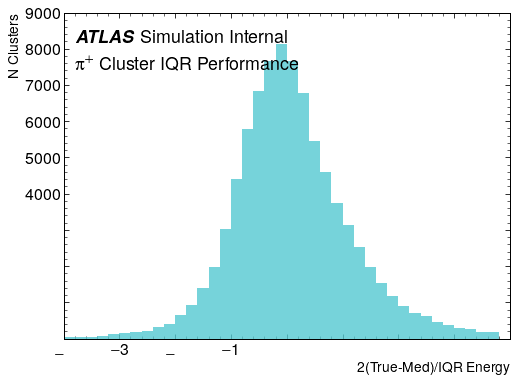

In [28]:
# distribution of differences from predicted mean
x = 2*(pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])/(pdata['piplus']['quantile_0.16']-pdata['piplus']['quantile_0.84'])
# x = (pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])

x_min = -4
x_max = 4
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

alpha = 0.8

plt.cla()
plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

sel = pdata['piplus'].test
plt.hist(x[sel], bins = xbin, density = False, alpha = alpha)

# sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] < pdata['piplus']['cluster_ENG_CALIB_TOT']) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] < pdata['piplus']['quantile_0.16'])
# plt.hist(x[sel], bins = xbin, density = False, alpha = alpha, label = 'Within 68\% IQR')
# n1 = len(x[sel])

# sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] > pdata['piplus']['cluster_ENG_CALIB_TOT'])
# plt.hist(x[sel], bins = xbin, density = False, alpha = alpha, label = 'Below 16\%')
# n0 = len(x[sel])

# sel = pdata['piplus'].test & (pdata['piplus']['cluster_ENG_CALIB_TOT'] > pdata['piplus']['quantile_0.16'])
# plt.hist(x[sel], bins = xbin, density = False, alpha = alpha, label = 'Above 84\%')
# n2 = len(x[sel])

# plt.yscale('log')
plt.xlim(x_min, x_max)
ampl.set_xlabel('2(True-Med)/IQR Energy')
ampl.set_ylabel('N Clusters')
ampl.draw_atlas_label(0.025, 0.95, simulation='internal', fontsize=18)
fig.axes[0].text(0.025, 0.825, "$\pi^{+}$ Cluster IQR Performance", transform=fig.axes[0].transAxes, fontsize=18)
# fig.axes[0].text(0.025, 0.75, label, transform=fig.axes[0].transAxes, fontsize=18)
plt.legend()
plt.savefig(plotpath+'iqr_accuracy.pdf')
plt.show()


No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

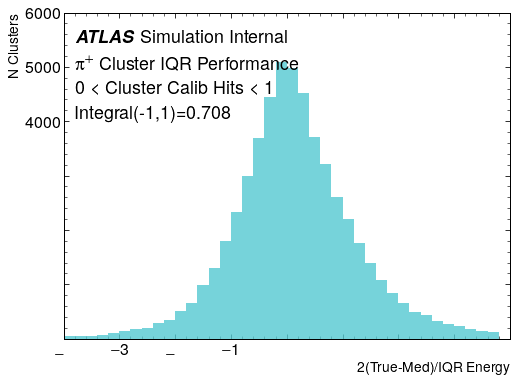

No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

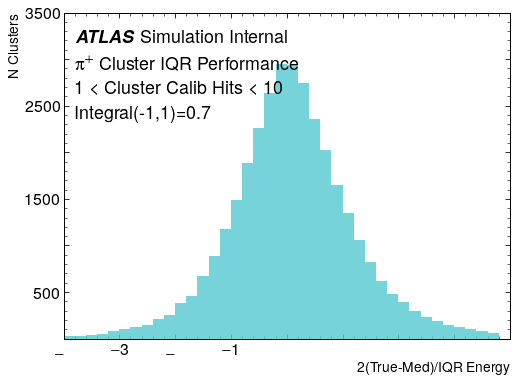

No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

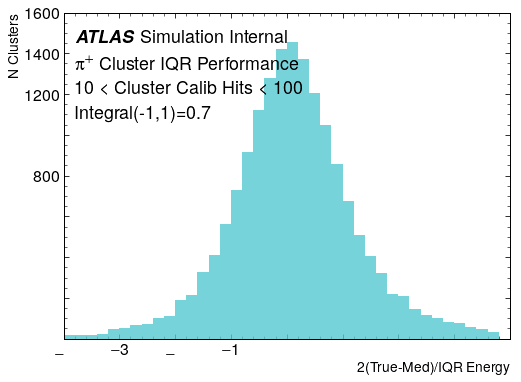

No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

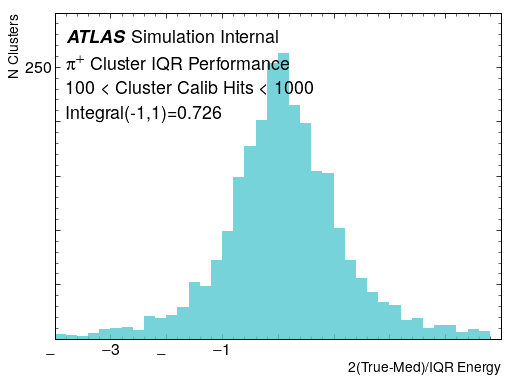

No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

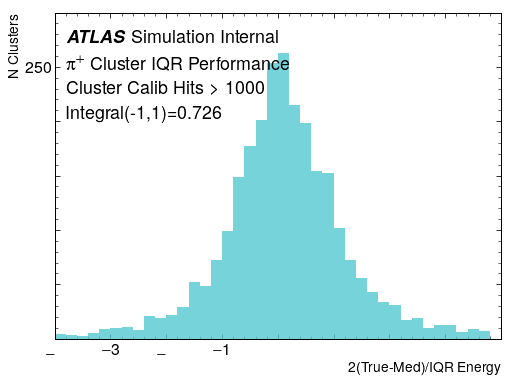

In [53]:
# distribution of differences from predicted mean
# binned in true energy
energy_bins = [0,1,10,100,1000]

x = 2*(pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])/(pdata['piplus']['quantile_0.16']-pdata['piplus']['quantile_0.84'])
# x = (pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])

x_min = -4
x_max = 4
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

alpha = 0.8

totals = np.zeros(len(energy_bins))
hists = []
for i in range(len(energy_bins)):
    if( i == len(energy_bins)-1 ):
        label = 'Cluster Calib Hits > '+str(energy_bins[i])
        sel_energy = pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]
    else:
        label = str(energy_bins[i])+' < Cluster Calib Hits < '+str(energy_bins[i+1])
        sel_energy = (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i+1])

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    sel = pdata['piplus'].test
    hists.append(
        plt.hist(x[sel & sel_energy], bins = xbin, density = False, alpha = alpha)
    )
    total = len(x[sel & sel_energy])
    inte = 0
    for j in range(15,25+1):
        inte += hists[i][0][j]
    ratio = str(round(float(inte)/total,3))

    # plt.yscale('log')
    plt.xlim(x_min, x_max)
    ampl.set_xlabel('2(True-Med)/IQR Energy')
    ampl.set_ylabel('N Clusters')
    ampl.draw_atlas_label(0.025, 0.95, simulation='internal', fontsize=18)
    fig.axes[0].text(0.025, 0.825, "$\pi^{+}$ Cluster IQR Performance", transform=fig.axes[0].transAxes, fontsize=18)
    fig.axes[0].text(0.025, 0.75, label, transform=fig.axes[0].transAxes, fontsize=18)
    fig.axes[0].text(0.025, 0.675, 'Integral(-1,1)='+ratio, transform=fig.axes[0].transAxes, fontsize=18)
    plt.legend()
    plt.savefig(plotpath+'iqr_accuracy_binned_'+str(i)+'.pdf')
    plt.show()


<Figure size 576x432 with 0 Axes>

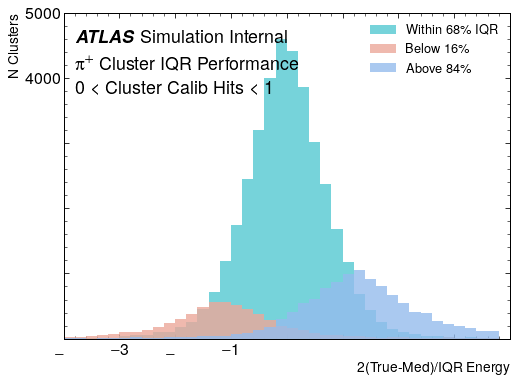

<Figure size 576x432 with 0 Axes>

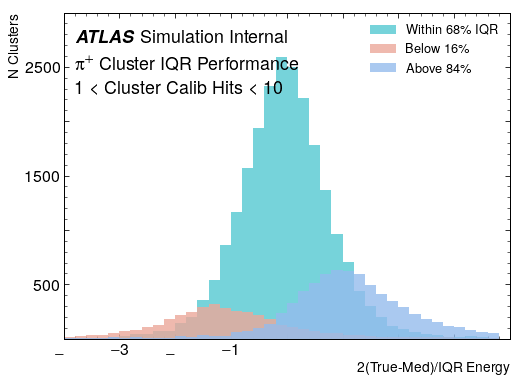

<Figure size 576x432 with 0 Axes>

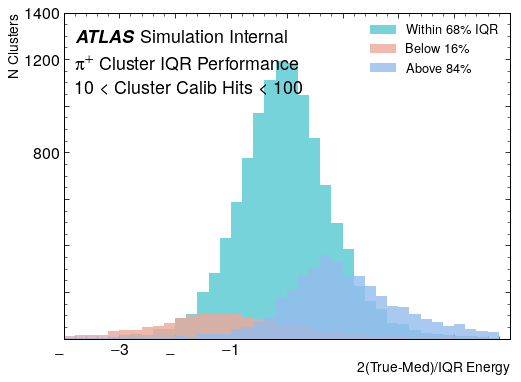

<Figure size 576x432 with 0 Axes>

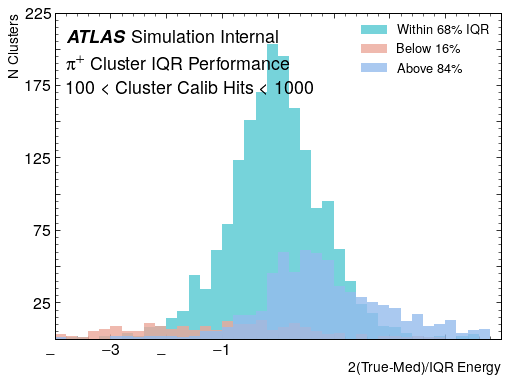

<Figure size 576x432 with 0 Axes>

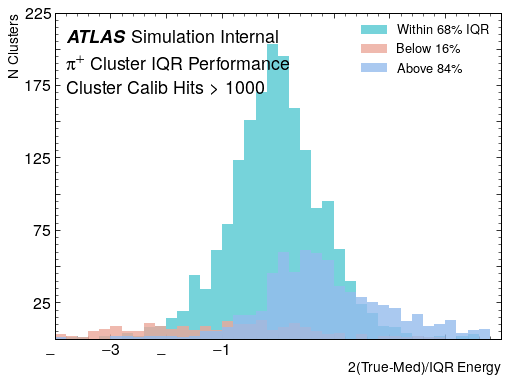

In [54]:
# partitioned distributions of differences from predicted mean
# binned in true energy
energy_bins = [0,1,10,100,1000]

x = 2*(pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])/(pdata['piplus']['quantile_0.16']-pdata['piplus']['quantile_0.84'])
# x = (pdata['piplus']['cluster_ENG_CALIB_TOT']-pdata['piplus']['quantile_0.5'])

x_min = -4
x_max = 4
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

alpha = 0.8

totals = np.zeros(len(energy_bins))
hists = []
for i in range(len(energy_bins)):
    if( i == len(energy_bins)-1 ):
        label = 'Cluster Calib Hits > '+str(energy_bins[i])
        sel_energy = pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]
    else:
        label = str(energy_bins[i])+' < Cluster Calib Hits < '+str(energy_bins[i+1])
        sel_energy = (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i]) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] > energy_bins[i+1])

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] < pdata['piplus']['cluster_ENG_CALIB_TOT']) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] < pdata['piplus']['quantile_0.16'])
    plt.hist(x[sel & sel_energy], bins = xbin, density = False, alpha = alpha, label = 'Within 68\% IQR')
    n1 = len(x[sel & sel_energy])

    sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] > pdata['piplus']['cluster_ENG_CALIB_TOT'])
    plt.hist(x[sel & sel_energy], bins = xbin, density = False, alpha = alpha, label = 'Below 16\%')
    n0 = len(x[sel & sel_energy])

    sel = pdata['piplus'].test & (pdata['piplus']['cluster_ENG_CALIB_TOT'] > pdata['piplus']['quantile_0.16'])
    plt.hist(x[sel & sel_energy], bins = xbin, density = False, alpha = alpha, label = 'Above 84\%')
    n2 = len(x[sel & sel_energy])

    # plt.yscale('log')
    plt.xlim(x_min, x_max)
    ampl.set_xlabel('2(True-Med)/IQR Energy')
    ampl.set_ylabel('N Clusters')
    ampl.draw_atlas_label(0.025, 0.95, simulation='internal', fontsize=18)
    fig.axes[0].text(0.025, 0.825, "$\pi^{+}$ Cluster IQR Performance", transform=fig.axes[0].transAxes, fontsize=18)
    fig.axes[0].text(0.025, 0.75, label, transform=fig.axes[0].transAxes, fontsize=18)
    plt.legend()
    plt.savefig(plotpath+'iqr_accuracy_partitioned_binned_'+str(i)+'.pdf')
    plt.show()

In [56]:
sel = pdata['piplus'].test

x = (pdata['piplus'][sel]['cluster_ENG_CALIB_TOT']-pdata['piplus'][sel]['quantile_0.5'])*2/(pdata['piplus'][sel]['quantile_0.16']-pdata['piplus'][sel]['quantile_0.84'])
np.std(x[(pdata['piplus'][sel]['quantile_0.16']-pdata['piplus'][sel]['quantile_0.84']) != 0])

12.186794

In [80]:
print(n0, n1, n2, n0+n1+n2)
print(len(pdata['piplus'][pdata['piplus'].test]['cluster_ENG_CALIB_TOT'])-(n0+n1+n2))

11624 59683 15981 87288
-95


<Figure size 576x432 with 0 Axes>

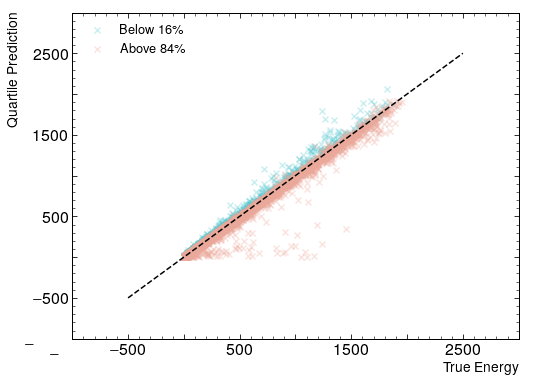

In [98]:

plt.cla()
plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

alpha = 0.3

x = pdata['piplus']['cluster_ENG_CALIB_TOT']

# sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] < pdata['piplus']['cluster_ENG_CALIB_TOT']) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] < pdata['piplus']['quantile_0.16'])
# plt.scatter(x[sel], y[sel], label = 'Within 68\% IQR')

y = pdata['piplus']['quantile_0.84']
sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] > pdata['piplus']['cluster_ENG_CALIB_TOT'])
plt.scatter(x[sel], y[sel], alpha = alpha, marker='x', label = 'Below 16\%')

y = pdata['piplus']['quantile_0.16']
sel = pdata['piplus'].test & (pdata['piplus']['cluster_ENG_CALIB_TOT'] > pdata['piplus']['quantile_0.16'])
plt.scatter(x[sel], y[sel], alpha = alpha, marker='x', label = 'Above 84\%')

plt.plot((-500, 2500), (-500, 2500), linestyle='--', color='k')

ampl.set_xlabel('True Energy')
ampl.set_ylabel('Quartile Prediction')
plt.legend()
plt.savefig(plotpath+'iqr_split.png')
plt.show()

<Figure size 576x432 with 0 Axes>

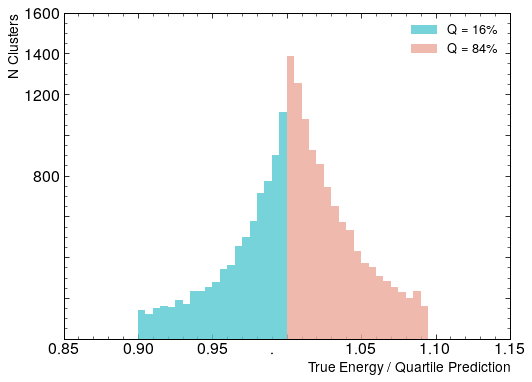

In [112]:
x_min = 0.9
x_max = 1.1
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

alpha = 0.8

plt.cla()
plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

x = pdata['piplus']['cluster_ENG_CALIB_TOT'] / pdata['piplus']['quantile_0.84']
sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] > pdata['piplus']['cluster_ENG_CALIB_TOT'])
plt.hist(x[sel], bins=xbin, alpha = alpha, label = 'Q = 16\%')

x = pdata['piplus']['cluster_ENG_CALIB_TOT'] / pdata['piplus']['quantile_0.16']
sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.16'] < pdata['piplus']['cluster_ENG_CALIB_TOT'])
plt.hist(x[sel], bins=xbin, alpha = alpha, label = 'Q = 84\%')

ampl.set_xlabel('True Energy / Quartile Prediction')
ampl.set_ylabel('N Clusters')
plt.legend()
plt.savefig(plotpath+'iqr_split.pdf')
plt.show()

<Figure size 576x432 with 0 Axes>

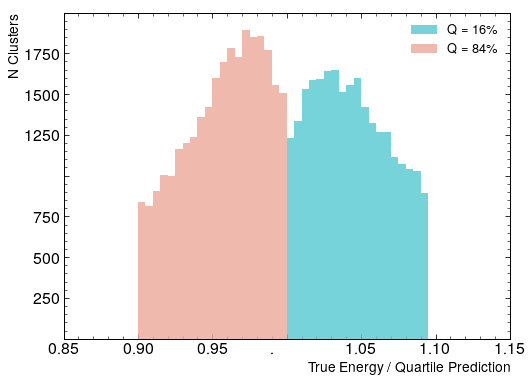

In [113]:
x_min = 0.9
x_max = 1.1
x_bins = 40
xbin = np.arange(x_min, x_max, (x_max - x_min) / x_bins)

alpha = 0.8

plt.cla()
plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

sel = pdata['piplus'].test & (pdata['piplus']['quantile_0.84'] < pdata['piplus']['cluster_ENG_CALIB_TOT']) & (pdata['piplus']['cluster_ENG_CALIB_TOT'] < pdata['piplus']['quantile_0.16'])


x = pdata['piplus']['cluster_ENG_CALIB_TOT'] / pdata['piplus']['quantile_0.84']
plt.hist(x[sel], bins=xbin, alpha = alpha, label = 'Q = 16\%')

x = pdata['piplus']['cluster_ENG_CALIB_TOT'] / pdata['piplus']['quantile_0.16']
plt.hist(x[sel], bins=xbin, alpha = alpha, label = 'Q = 84\%')

ampl.set_xlabel('True Energy / Quartile Prediction')
ampl.set_ylabel('N Clusters')
plt.legend()
plt.savefig(plotpath+'iqr_split.pdf')
plt.show()